# Machine translation services: Comparison of usage at target languages where available

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

**Last Update: 24 October 2022**

[Ticket](https://phabricator.wikimedia.org/T310773) | [Codebase](https://github.com/wikimedia-research/machine-translation-service-analysis-2022)

# Table of Contents

1. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Overall usage by machine translation service](#Overall-usage-by-machine-translation-service)
4. [Daily published translations](#Daily-published-translations)
5. [Usage by language pair](#Usage-by-language-pair) 
6. [Usage at each target language](#Usage-at-each-target-language)
7. [Percent machine translation content is modified](#Percent-machine-translation-content-is-modified)
8. [Percent of articles that are created with each MT service and deleted](#Percent-of-articles-that-are-created-with-each-MT-service-and-deleted)
    

# Purpose
Content translation supports multiple machine translation services.  When multiple options are available for a language, even if one is provided by default, users can use a different service. 
[See default configuration](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) and [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) files for details on all available language pairs and defaults. 

An [initial report](https://github.com/wikimedia-research/machine-translation-service-analysis-2022/blob/main/mt_service_comparison.ipynb) was completed in May 2022 to understand how the various available machine translation services are used at all the available target languages. The initial report informed some changes in the services provided by default on certain language pairs. 

In this report, we re-ran the analysis to determine the impact of changes that occurred following the initial report including: 
1. Changes to default services at certain language pairs [T309266](https://phabricator.wikimedia.org/T309266). Deployed on 15 June 2022.
2. Support from different machine translation services for new languages:
* Flores deployed to more language pairs on 21 June 2022. [T307970](https://phabricator.wikimedia.org/T307970): 
* Google Translate deployed to more language pairs on July 27th. [T308248](https://phabricator.wikimedia.org/T308248).

# Methodology

For each machine translation service, we compared the following:
* Percent of translations published by each machine translation service:
    * Overall across all languages
    * Daily usage trends
    * Usage at each Language Pair (Source - Target)
    * Most frequently used service for each target Language
* Percent each machine translation service was modified by users
* Percent of articles created with each machine translation service that were deleted.

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table?useskin=vector-2022)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table?useskin=vector-2022)

We reviewed only published translations and translations started on or after 1 February 2022, which was when the new machine translation service, NLLB-200 was deployed, through 20 September 2022.

Modifications to the initial report: 
* Identified cases where optional services were used close to the default services (within 20 percentage points) in addition to cases where optional services were used are higher than the defaults.
* Included deletion rates in the Machine Translation Engine Modifications graph to more understand the quality of articles translated.
* Included more languages in the Machine translation modifications graph to reflect all the languages currently supported by Flores. 

In [13]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [14]:
# load required R packages
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); 
    library(lubridate); 
    library(gt);
    library(gtsummary)
})

In [17]:
# load data
mt_data <-
  read.csv(
    file = 'Data/mt_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all cx data

In [18]:
#convert date back to integer

mt_data$translation_start_time <- format(mt_data$translation_start_time, scientific=F)

In [19]:
# convert time sent to date time
mt_data$translation_start_time <- as.Date(mt_data$translation_start_time, format = "%Y%m%d%H%M%S")

In [20]:
# only review published translations
# remove source and final rows
 #remove non mt service translations
mt_service_compare <- mt_data %>%
    filter(translation_status == 'published',
            translation_type == 'mt_engine',
          translation_start_time >= '2022-02-01') %>%
    mutate(language_pair = paste0(source_language, "-" ,target_language), # add language pair colum
           mt_service = case_when(  # combine duplicate MT service categories
               mt_service == 'Yandex.Translate' ~ 'Yandex',
               mt_service == 'Google Translate' ~ 'Google',
               mt_service == 'Flores' ~ 'NLLB-200',
               TRUE ~ as.character (mt_service)),
          mt_service = factor(mt_service,
                             levels = c("Yandex", "LingoCloud", "Apertium", "Elia", "OpusMT", "Google", "scratch", "NLLB-200"))) 


                 

In [23]:
# save revision ids and MT for deletion ratio analysis

mt_service_compare_ids <- mt_service_compare %>%
  select(c(3,9))

write_csv(mt_service_compare_ids, "Data/mt_service_compare_ids.csv")

# Percent of translations published

## Overall usage by machine translation service

We first reviewed overall usage of each machine translation service across all source and target languages from 01 February 2022 through 20 September 2022. 

Note: Each translation service supports a different set of languages. Additionally, there are different default services provided for each language pair (i.e. the source and target language). Please see the [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) for details on supported languages by MT service.  Each machine translation service's availability and default status at various language pairs impact the numbers reflected below.

In [55]:
# Overall look at translations by MT engine

mt_compare_overall <- mt_service_compare %>%
    group_by(mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = paste0(round(num_translations/sum(num_translations) * 100, 2), "%"))  %>%
    arrange(desc(pct_translations))


`summarise()` ungrouping output (override with `.groups` argument)



In [58]:
mt_compare_overall_tbl <- mt_compare_overall %>%
  gt() %>%
  tab_header(
    title = "Published translations by machine translations service \n across all language pairs",
      subtitle = "1 Feb 2022 through 20 Sept 2022"
  )  %>%
  cols_label(
    mt_service = "Machine translation service",
    num_translations = "Number of translations",
    pct_translations = "Percent of all published translations",
  ) %>%
  tab_footnote(
    footnote = "Translation started from scratch. No machine translation content was used.",
    locations = cells_body(
      columns = 'mt_service', rows = 2)) %>%
    gtsave(
    "mt_compare_overall_tbl.html", inline_css = TRUE)

IRdisplay::display_html(data = mt_compare_overall_tbl, file = "mt_compare_overall_tbl.html")


1 Translation started from scratch. No machine translation content was used.


### Findings
* Google translate, which can be used to translate into all available languages except English, has been used for the majority (81.77%) of published translations across all language pairs. 
* NLLB-200 (formerly called Flores) is now the third most used machine translation engine accounting for 3.8% of all published translations.
* 5.3% of published translations are started from scratch (no machine translation content was used).

## Changes in machine translation usage since the first report

In [59]:
# Comparison to first report

mt_compare_report_versions <- mt_service_compare %>%
    mutate(report_date = ifelse(translation_start_time <= '2022-05-27', 'first_report', 'second_report')) %>%
    group_by(report_date, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = paste0(round(num_translations/sum(num_translations) * 100, 2), "%"))  %>%
    select(-3) %>% # remove unneeded column
    spread(report_date, pct_translations) %>%
    arrange(desc(second_report))


`summarise()` regrouping output by 'report_date' (override with `.groups` argument)



In [68]:
mt_compare_report_versions_tbl <- mt_compare_report_versions %>%
  gt() %>%
  tab_header(
    title = "Published translations by machine translations service \n across all language pairs",
      subtitle = "Pre and Post MT Service Changes"
  )  %>%
  cols_label(
    mt_service = "Machine translation service",
    first_report = "Prior to start of mt service changes \n(01 Feb 2022 - 15 June 2022)",
    second_report = "Post start of mt service changes \n(15 June 2022 - 20 Sept 2022)",
  ) %>%
  tab_footnote(
    footnote = "Translation started from scratch. No machine translation content was used.",
    locations = cells_body(
      columns = 'mt_service', rows = 3)) %>%
tab_footnote(
    footnote = "MT service changes includes different translation services for new languages \n
and changes in default service settings",
    locations = cells_title(groups = "subtitle")) %>%
    gtsave(
    "mt_compare_report_versions_tbl.html", inline_css = TRUE)

IRdisplay::display_html(data = mt_compare_report_versions_tbl, file = "mt_compare_report_versions_tbl.html")


1 MT service changes includes different translation services for new languages and changes in default service settings 2 Translation started from scratch. No machine translation content was used.


We also compared any changes in the proportion of published translations from the 4 months reviewed in the first report prior the start of the machine translation service changes (01 Feb 2022 - 15 June 2022) to the time period following (16 June 2022 - 20 Sept 2022) to check how the usage pattern evolved following  various deployments and changes to default settings that were made after the first report. 

### Findings
* The biggest changes in usage were observed for NLLB-200 (5 percentage point increase [0.95% to 6.05%]) and Apertium (4.3 percentage point decrease [6.64% to 2.31%]) machine translation service since the first report was run.
* We've also observed a significant decrease in the percent of published translations started from scratch (no machine translation content was used) (2.7 percentage point decrease [6.85% to 4.17%]).
* Only slight changes were observed for the other machine translation services. Usage of Google has increased slightly while usage of Yandex, Elia, OputMT and LingoCloud slightly decreased.



## Daily published translations

We reviewed translations published per day by each MT service to identify any sudden increases or decreases in usage and see if those changes correspond to the once of the deployments or setting changes that may have impacted MT availability.

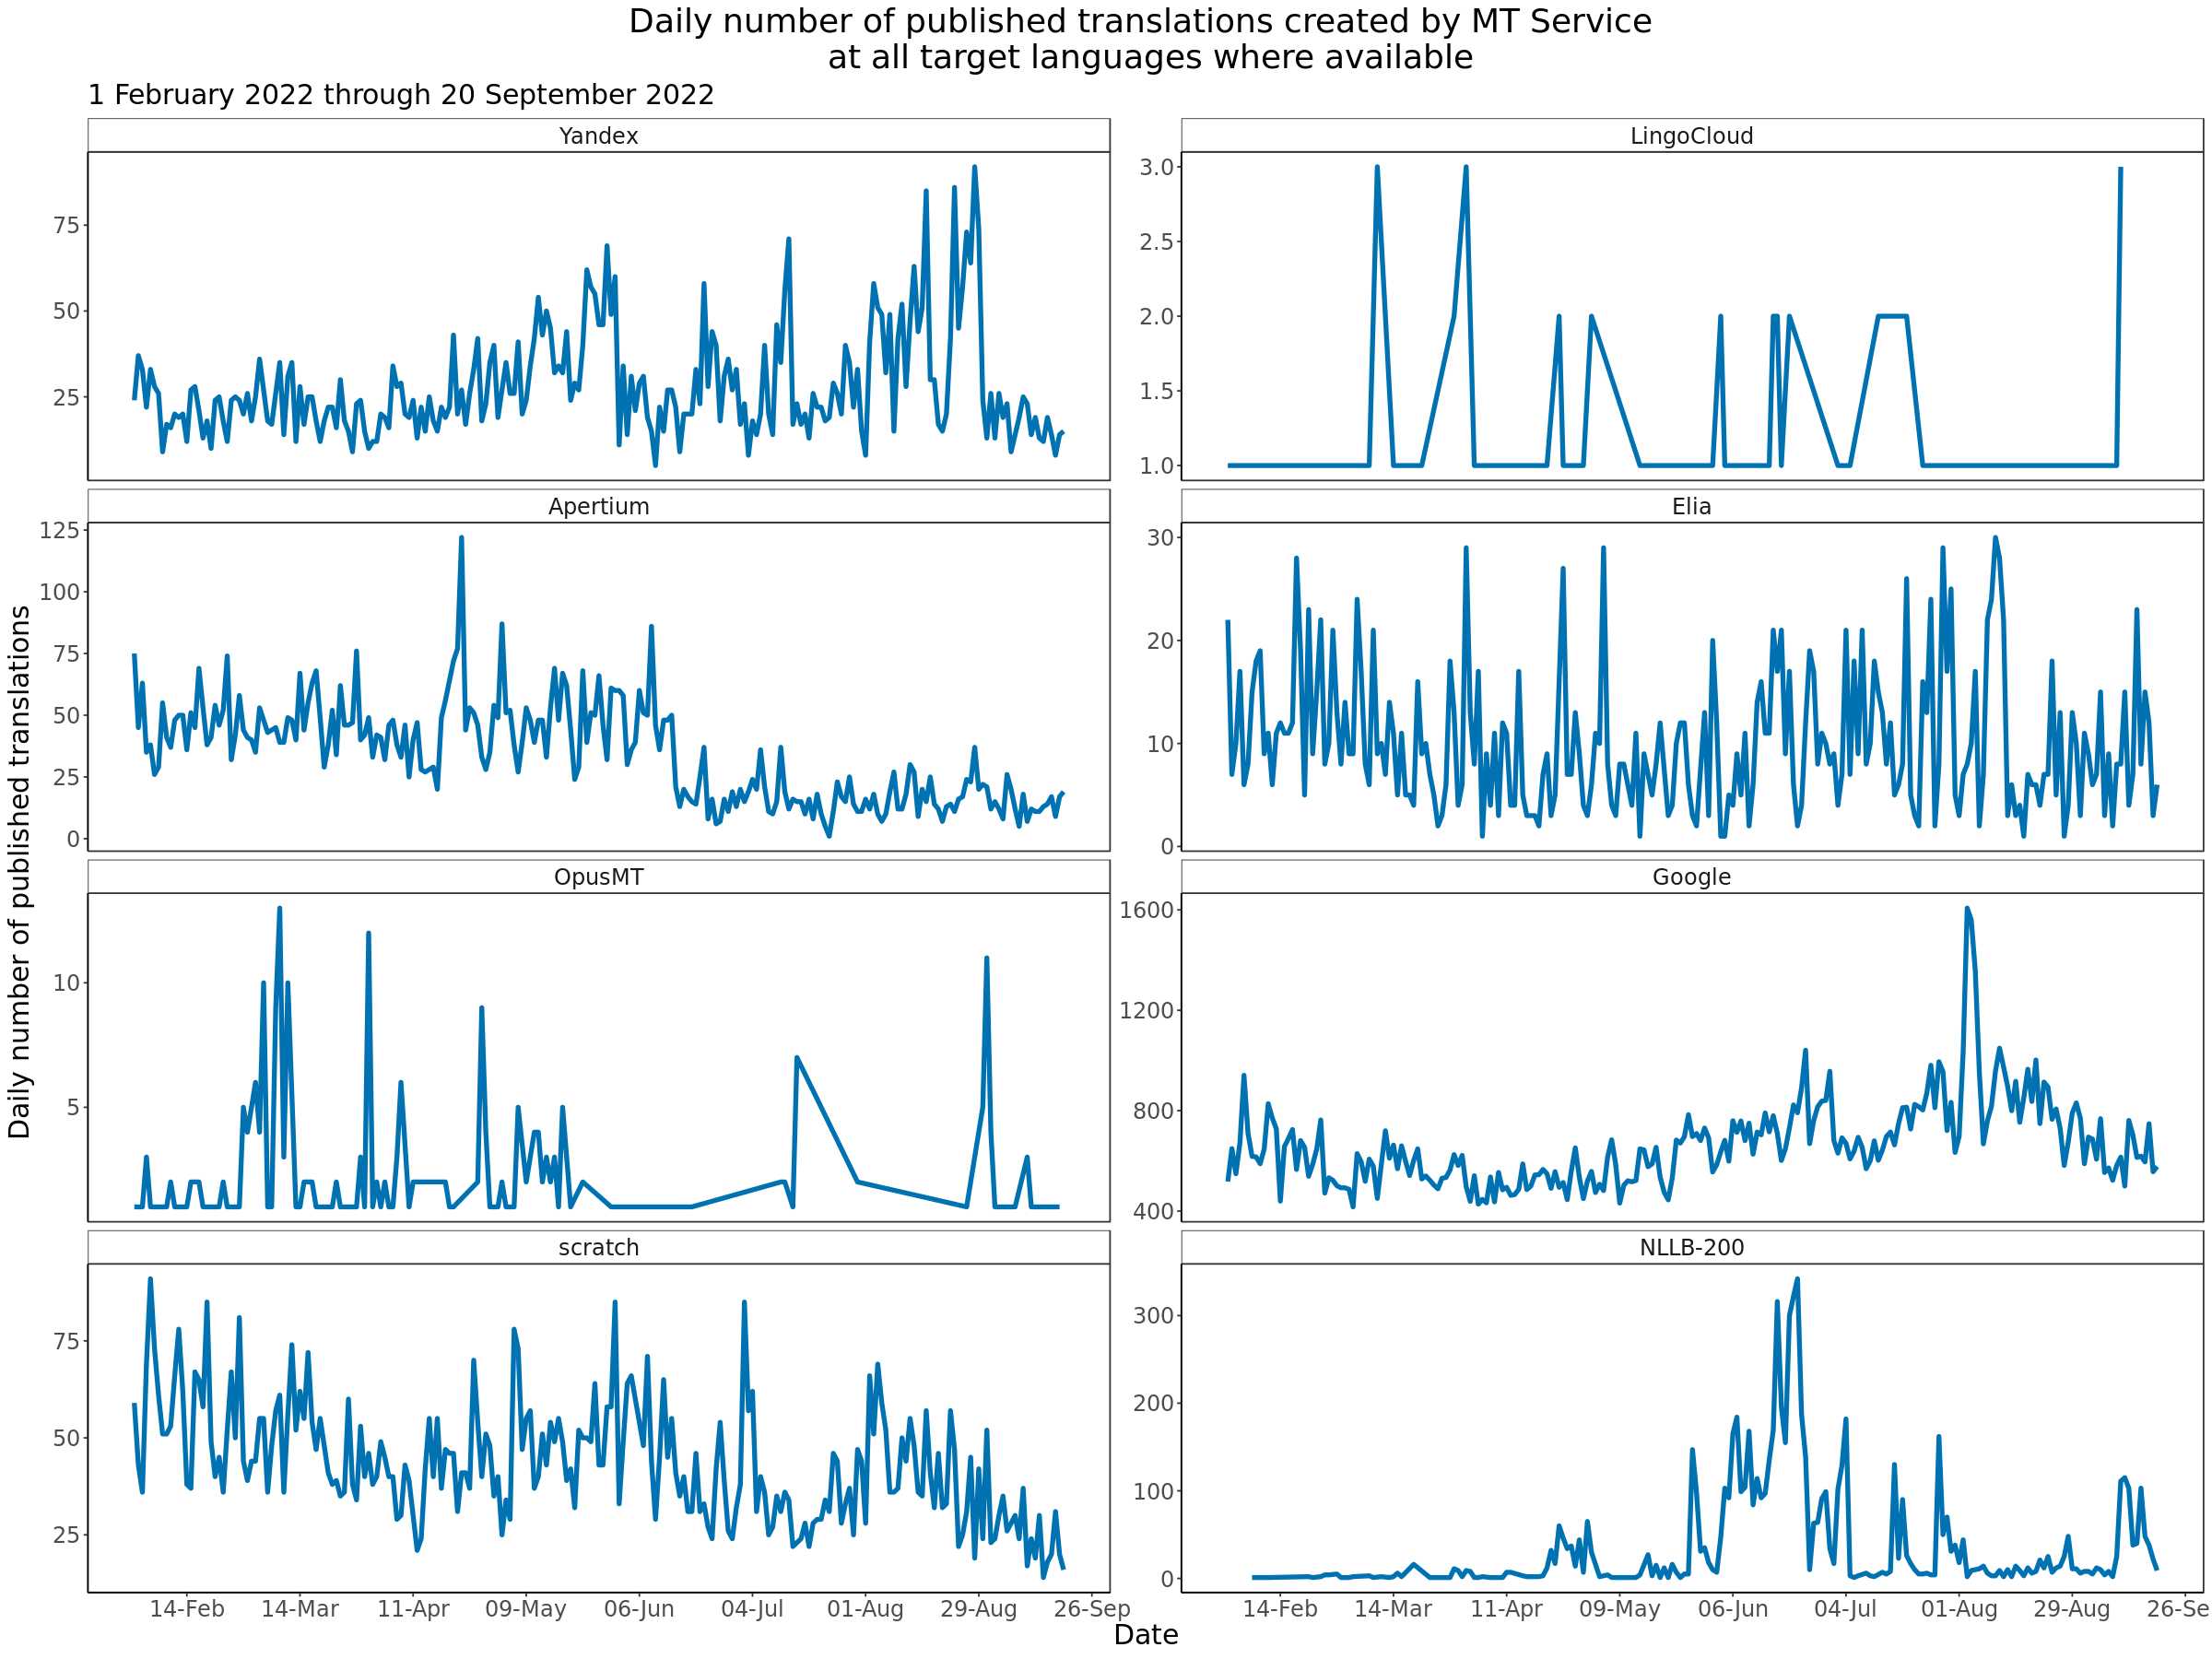

In [69]:
# plot daily usage trends
options(repr.plot.width = 20, repr.plot.height = 15)


p <- mt_service_compare %>%
    filter(translation_start_time < '2022-09-20')  %>% #incomplete data on the Sept 20th
    group_by(translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id), .groups = 'drop')  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations)) +
    geom_line(size = 1.5, color = "#0072B2") +
    facet_wrap(~mt_service, scale = "free_y", ncol = 2) + 
    scale_x_date(date_labels = "%d-%b", date_breaks = "4 weeks", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily number of published translations created by MT Service \n at all target languages where available",
         subtitle = "1 February 2022 through 20 September 2022")  +
    theme_bw() +
   theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"))
            

ggsave("Figures/mt_service_usage_byday.png", p, width = 16, height = 8, units = "in", dpi = 300)

p

### Findings:
* We observed a decrease in Apertium usage on 15 June 2022. This coincides with the change to default services at certain language pairs in [T309266](https://phabricator.wikimedia.org/T309266), where Google replaced Apertium as the default service at several language pairs. 
* There was a steady increase in Google Translate usage, with a peak of 1607 daily translations on 03 August 2022 around the time that Google Translate was deployed to additional language pairs in [T308248](https://phabricator.wikimedia.org/T308248) and Content Translation was enabled by default on those Wikipedias [T313296](https://phabricator.wikimedia.org/T313296). 
* There was a spike in NLLB-200 usage on 22 June 2022 to 342 published translations in one day. This is one day following when it was deployed to more language pairs in [T307970](https://phabricator.wikimedia.org/T307970). Following this peak, usage of this MT service decreased to an average of around 50 translations published per day. 
* There has been a steady decrease in translations published without using any MT service ("scratch") as machine translation services have been made available to new language pairs.


## Usage by language pair

We reviewed the number and percent of publications by each machine translation service at each langauage pair (i.e. source language and target language). Due to the large combination of language pairs, data was saved to google [spreadsheet](https://docs.google.com/spreadsheets/d/1qLNWAnofzxOAfbvqLJBKmyh2chMz9Y8zwybFDqemWpc/edit#gid=1382755386) to easily filter and identify percent of publications by language pair for each machine translation service. 

In [70]:
# Compare overall usage by source and target
mt_compare_bylangpair <- mt_service_compare %>%
    group_by(source_language, target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'source_language', 'target_language' (override with `.groups` argument)



In [37]:
# Save aggregated data for further exploration in google doc
write_csv(
    x = mt_compare_bylangpair,
    file = 'Data/mt_compare_bylangpair.csv',
    col_names = TRUE)
  

## Languge pairs where an optional service was used more or close to the default

While reviewing the usage by language pair, we highlighted any optional services that are used more often or close as often (within 20%) as the default service for each language pair available. Note. Languages with 3 or fewer translations published during the reviewed time period were excluded.

Notes: This data can also be found on the "MT Service Usage Higher or Close to Defaults" of the Google [spreadsheet](https://docs.google.com/spreadsheets/d/1qLNWAnofzxOAfbvqLJBKmyh2chMz9Y8zwybFDqemWpc/edit#gid=1382755386) 


In [71]:
# load data
mt_defaults_flagged <-
  read.csv(
    file = 'Data/mt_defaults_flagged.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all cx data

In [72]:
mt_optional_services_used_more <- mt_defaults_flagged %>%
    group_by(default_service) %>%
    filter(mt_service_used != default_service &
           percent_translations_bypair > 0.30) %>%
    mutate(percent_translations_bypair = paste0(round(percent_translations_bypair * 100,2), "%"))
#conditions used to identify optional services used close or higher



In [73]:
mt_optional_services_used_more_tbl <- mt_optional_services_used_more%>%
  gt() %>%
  tab_header(
    title = "Optional machine translation services used close to or more than the default service",
      subtitle = "Reviewed timeframe: 01 Feb 2022 - 20 Sept 2022"
  )  %>%
  cols_label(
    default_service = "Default Service",
    source_language = "Source Language",
    target_language = "Target Language",
    mt_service_used = "Machine Translation Service Used",
    n_translations = "Number of Translations",
    percent_translations_bypair = "Percent of Translations at Language Pair"
  )  %>%
    gtsave(
    "mt_optional_services_used_more_tbl.html", inline_css = TRUE)

IRdisplay::display_html(data = mt_optional_services_used_more_tbl, file = "mt_optional_services_used_more_tbl.html")


<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Optional machine translation services used close to or more than the default service 
 
 
 Reviewed timeframe: 01 Feb 2022 - 20 Sept 2022 
 
 
 
 
 Source Language 
 Target Language 
 Machine Translation Service Used 
 Number of Translations 
 Percent of Translations at Language Pair 
 
 
 
 
 Apertium 
 
 
 be 
 ru 
 Google 
 399 
 89.7% 
 
 
 bg 
 mk 
 Google 
 40 
 95.2% 
 
 
 es 
 ca 
 Google 
 543 
 35.6% 
 
 
 es 
 gl 
 Google 
 397 
 44.2% 
 
 
 gl 
 pt 
 Google 
 18 
 54.5% 
 
 
 id 
 ms 
 Google 
 87 
 50.6% 
 
 
 mk 
 sr 
 Google 
 6 
 50% 
 
 
 ms 
 id 
 scratch 
 6 
 35.3% 
 
 
 nl 
 af 
 Google 
 18 
 60% 
 
 
 sl 
 sr 
 Google 
 4 
 66.7% 
 
 
 NLLB-200 
 
 
 en 
 is 
 Google 
 27 
 42.9% 
 
 
 Google 
 
 
 en 
 zu 
 NLLB-200 
 8 
 53.3% 
 
 
 an 
 es 
 Apertium 
 12 
 100% 
 
 
 ast 
 es 
 Apertium 
 2 
 50% 
 
 
 eu 
 es 
 Apertium 
 15 
 38.5% 
 
 
 it 
 es 
 Apertium 
 154 
 62.9% 
 
 
 pt 
 es 
 Apertium 
 98 
 39% 
 
 
 ro 
 es 
 Apertium 
 6 
 60%

## Usage at each target language

We next took a closer look at each machine translation service, identifying its usage at all target languages where available and identifying the languages each service is helping to support the most. 

Key observations are summarized below.

Notes: 
* The charts below do not include target languages where the service is available but was not used during the reviewed timeframe. 
* The reviwed data period is from February 2022 through 20 September 2022. During this time, there were several changes to default settings and deployment of new MT services at various language pairs. 

Please see the [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) for details on all supported languages by MT service.

### Yandex

Since 4th November 2015, Yandex machine translation system has been available for users of Content Translation and has been used to translate 3.4% of all published translations since February 2022. It is available for more than 70 languages but not available when creating pages into English.  

You can find more details on the [Yandex mediawiki page](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Yandex&useskin=vector-2022).

In [74]:
# list of languages where yandex was used in language pairs
yandex_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'Yandex']

In [75]:
# restrict to usage of yandex in different langauges where available
yandex_data <- mt_service_compare %>%
    filter(target_language %in% yandex_languages)  

In [76]:
# Compare usage by target language
yandex_usage_compare_bytarget <- yandex_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [77]:
# order target languages based on factor levels

lvls <- as.character(yandex_usage_compare_bytarget$target_language[yandex_usage_compare_bytarget$mt_service=="Yandex"])[order(yandex_usage_compare_bytarget$pct_translations[yandex_usage_compare_bytarget$mt_service=="Yandex"])]
yandex_usage_compare_bytarget$target_language<- factor(yandex_usage_compare_bytarget$target_language,levels=lvls)

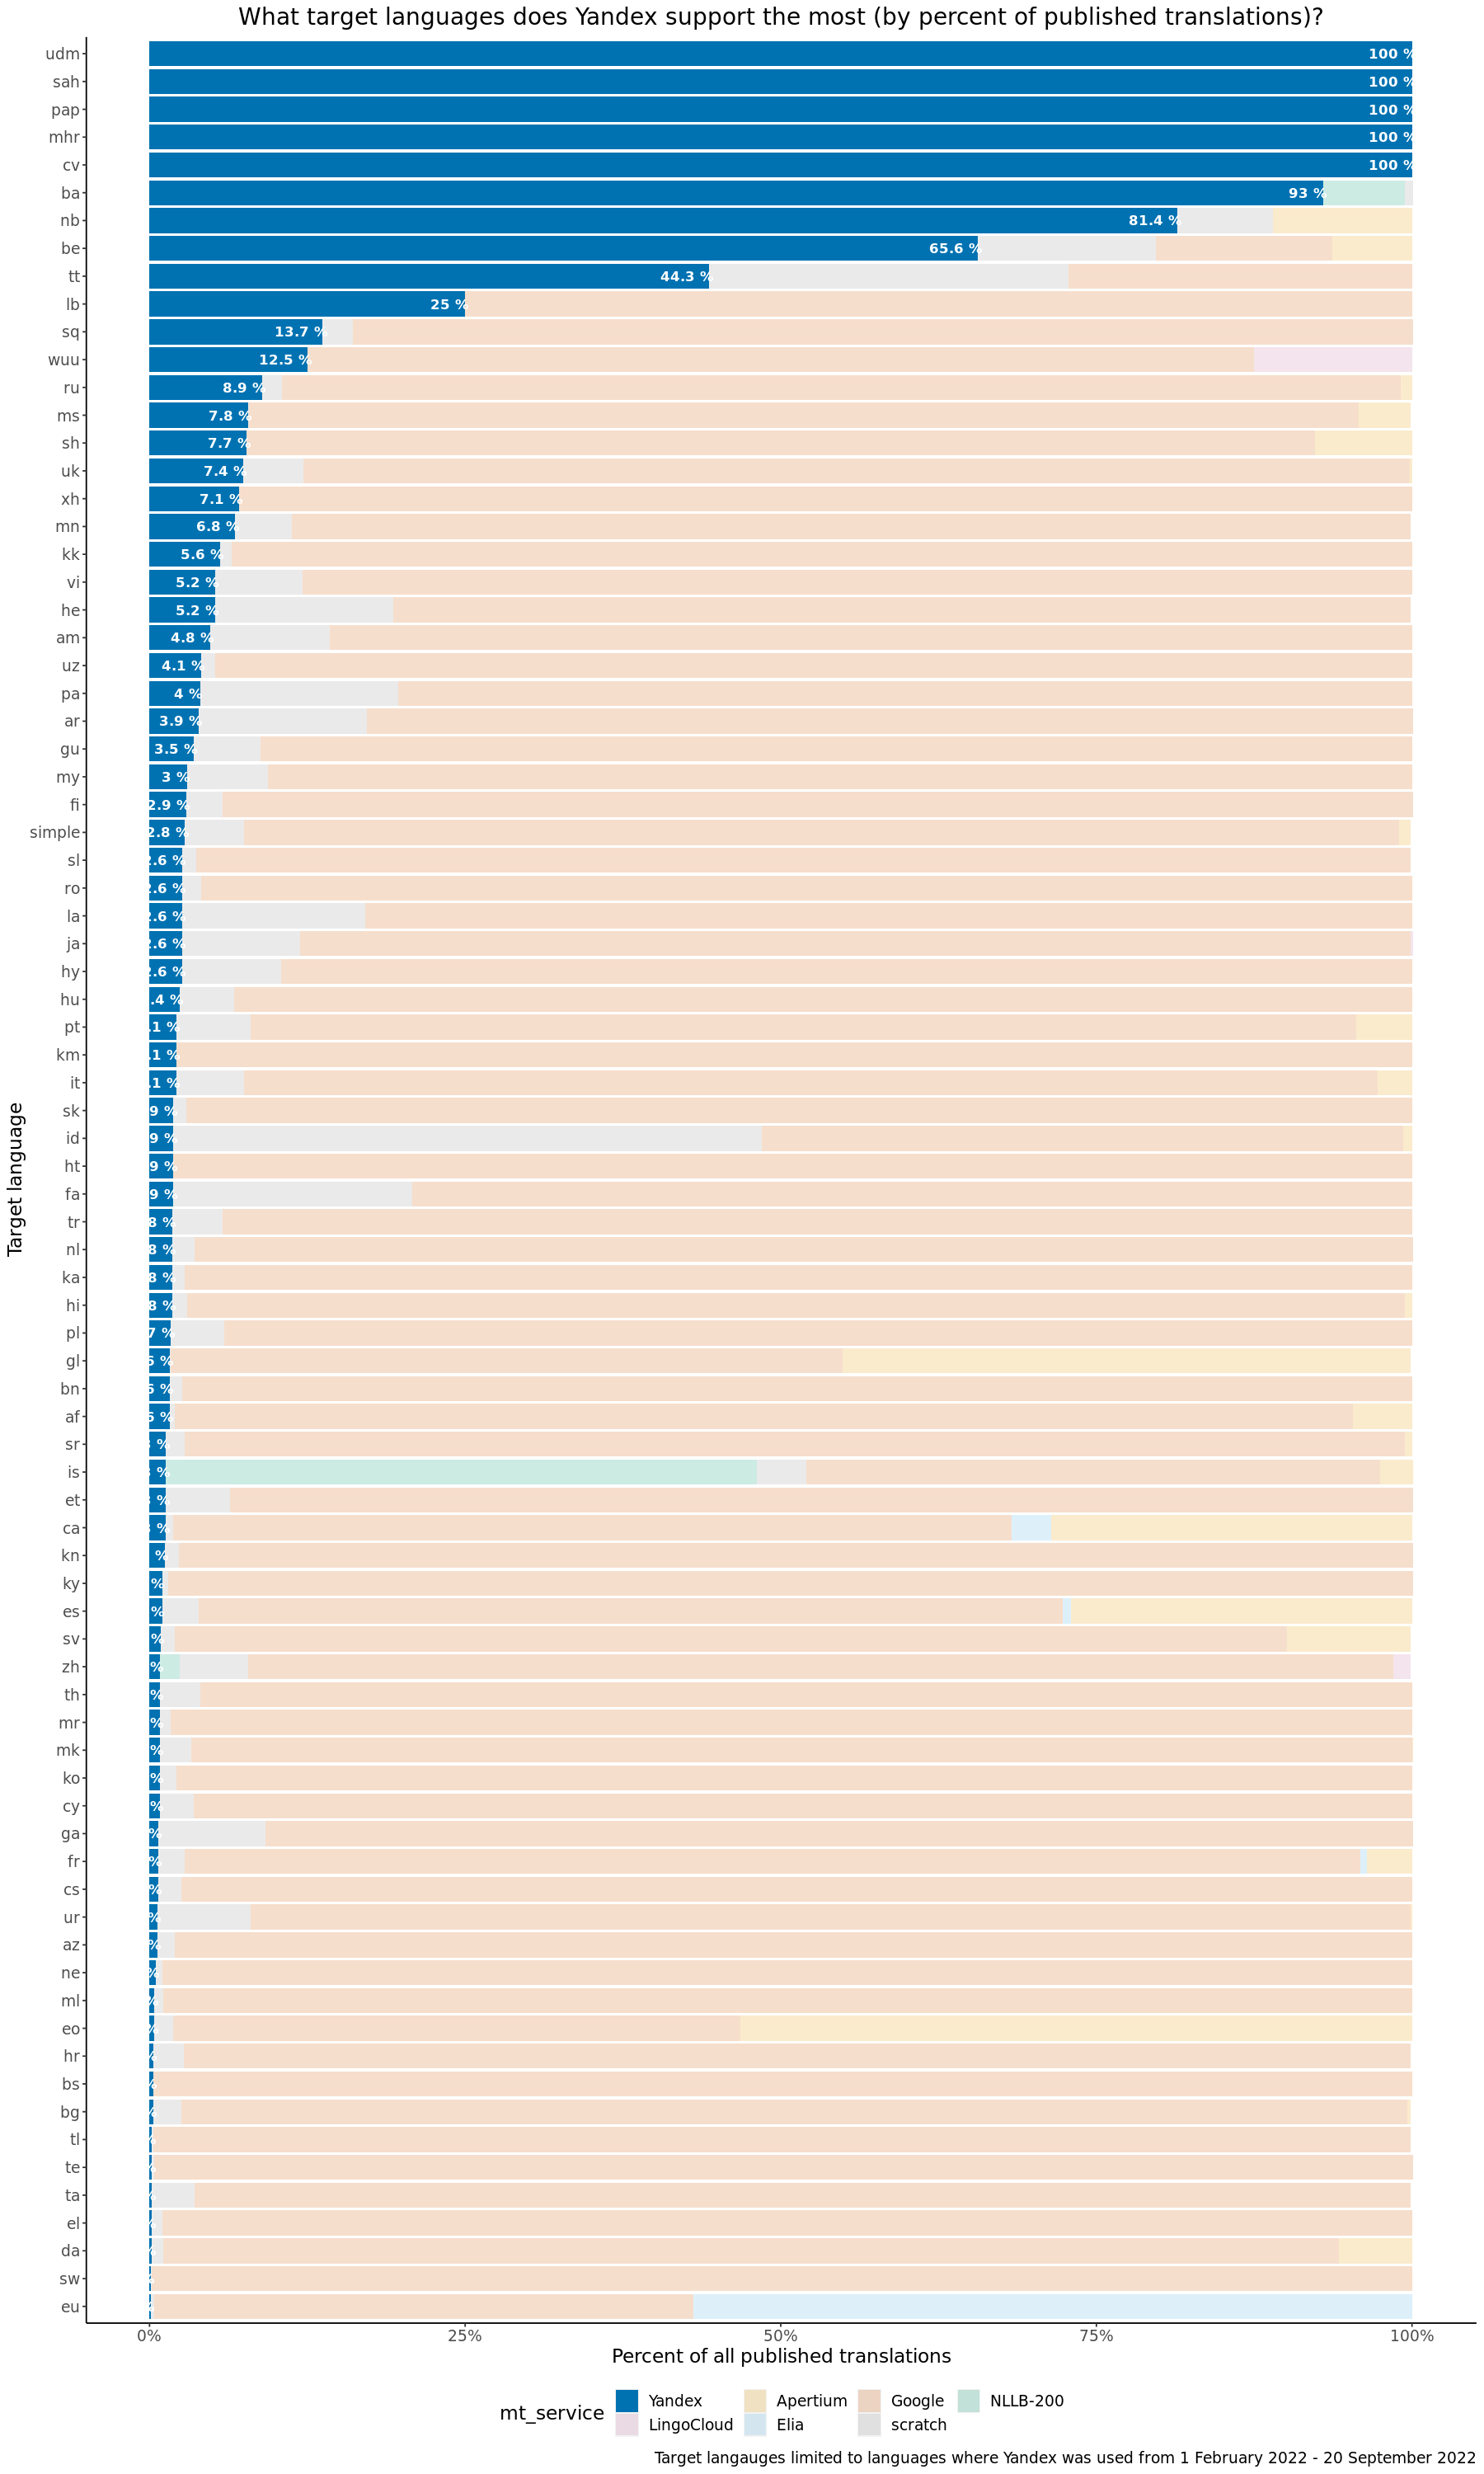

In [78]:
options(repr.plot.width = 15, repr.plot.height = 25)

p <- yandex_usage_compare_bytarget %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'Yandex', paste(round(pct_translations * 100,2), "%"), " "))) +
        geom_bar(aes(alpha = mt_service == 'Yandex'), stat = 'identity') +
        scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.2), guide = F) +
        coord_flip() +
        geom_text(size = 3.5, fontface = "bold", color = 'white', hjust = 0.9) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does Yandex support the most (by percent of published translations)?",
              caption = "Target langauges limited to languages where Yandex was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(1,0.2, 0.2,0.2,0.2, 0.2, 0.2)))) +
         scale_fill_manual(values = c("#0072B2", "#CC79A7","#E69F00", "#56B4E9","#D55E00", "#999999","#009E73" )) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/yandex_usage_compare_bytarget.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    
    

**Most popular target languages:**
* Yandex is currently used to support 100% of published translations at Udmurt (udm), Sakha (sah), Papiamentu (pap), Meadow Mari (mhr), and Chuvash (cv). 
* For target languages where other translation services were also used, Yandex is used most frequently at Bashkir (ba), Norwegian (Bokmål) (nb), Belarusian (be), and Tatar (tt). 


**Key changes from previous report:**
* Russian (ru)-Belarusian (be) default changed to Yandex in June 2022 
  * Yandex is now offered as the default for this language pair and has been used for 53.10% of translations. This is a 20.7% increase from the percent of Yandex translations identified in the prior report. We also observed a decrease in the percent of translations using Google and completed without an MT service ("scratch")  for this language pair. 
* Bashkir (ba) now has about 6% of published translations that were created using NLLB-200, which was deployed in June 2022 as a non-default service to the language.  To date,  NLLB-200 has only been used for the Russian (ru) to Bashkir (ba) language pair (6.5%, 45 translations) and English(en)- Bashkir (ba) language pair (50%, 1 translation). 
  


### LingoCloud

LingoCloud provides machine translation services between English, Chinese and Japanese languages. In August 2022, this supported was also provided to Wu (wuu) Wikipedia as part of [T199523](https://phabricator.wikimedia.org/T199523). It hasbeen used to translate 0.04% of all published translation since February 2022.

You can find more details on the [LingoCloud mediawiki page](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/LingoCloud&useskin=vector-2022)

In [79]:
# list of target language where lingo was used
lingocloud_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'LingoCloud']

In [80]:
# restrict to usage of lingo in different langauges where available
lingocloud_data <- mt_service_compare %>%
    filter(target_language %in% lingocloud_languages)  

In [81]:
# Compare usage
lingocloud_usage_compare <- lingocloud_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = num_translations/sum(num_translations))  %>%
    arrange(desc(pct_translations))
 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [82]:
# order target languages based on factor levels

lvls <- as.character(lingocloud_usage_compare$target_language[lingocloud_usage_compare$mt_service=="LingoCloud"])[order(lingocloud_usage_compare$pct_translations[lingocloud_usage_compare$mt_service=="LingoCloud"])]
lingocloud_usage_compare$target_language <- factor(lingocloud_usage_compare$target_language,levels=lvls)

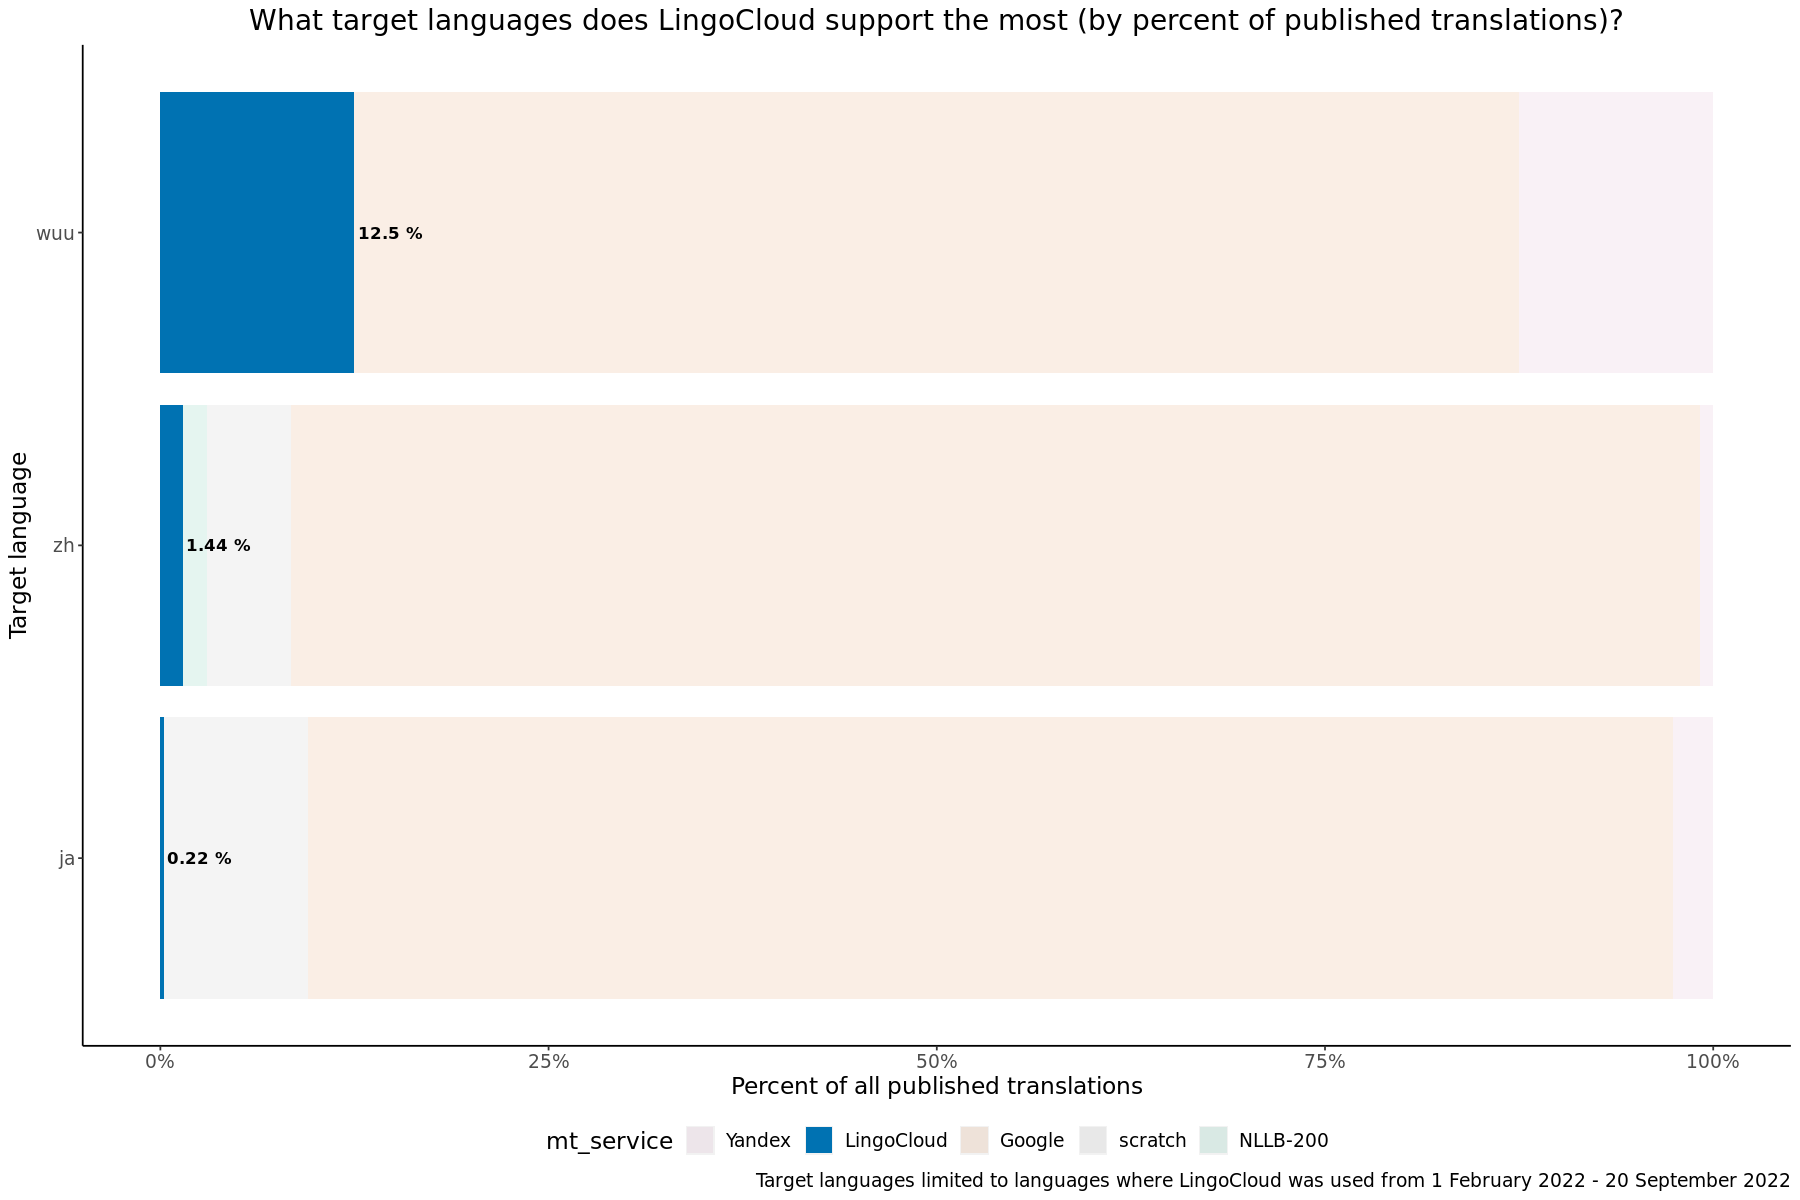

In [83]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- lingocloud_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'LingoCloud', paste(round(pct_translations * 100,2), "%"), " ")))  +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'LingoCloud'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.1), guide = F) +
        geom_text(size = 3.5, fontface = "bold", color = 'black', hjust = -0.05) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does LingoCloud support the most (by percent of published translations)?",
               caption = "Target languages limited to languages where LingoCloud was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.1,1, 0.1, 0.1, 0.1)))) +
         scale_fill_manual(values = c("#CC79A7", "#0072B2", "#D55E00", "#999999" ,"#009E73" )) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/lingocloud_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

**Most popular target languages:**
* LingoCloud has been used at less than 1.5% of published translations across all the target languages where available.
* LingoCloud has been used for 12.5% of translations at Wu (wuu) Wikipedia since made available in August 2022 (However this percentage only represents 1 translation from English (en) to Wu (wuu) as there are very few published translations for this target language). 
* Google Translate is still used for the majority of published translations at Japanese, Chinese, and Wu target languages. 

### Apertium

Apertium has about 37 language pairs for supporting machine translation and is the second most used machine translation service (4.2% of all published translations). You can find more details on the [Apertium mediawiki page](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Apertium&useskin=vector-2022)

In [84]:
# list of languages where Apertium was used in target language
apertium_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'Apertium']

In [85]:
# restrict to usage of Apertium in different langauges where available
apertium_data <- mt_service_compare %>%
    filter(target_language %in% apertium_languages)  

In [86]:
# Compare usage
apertium_usage_compare <- apertium_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [87]:
# order target languages based on factor levels

lvls <- as.character(apertium_usage_compare$target_language[apertium_usage_compare$mt_service=="Apertium"])[order(apertium_usage_compare$pct_translations[apertium_usage_compare$mt_service=="Apertium"])]
apertium_usage_compare$target_language <- factor(apertium_usage_compare$target_language,levels=lvls)

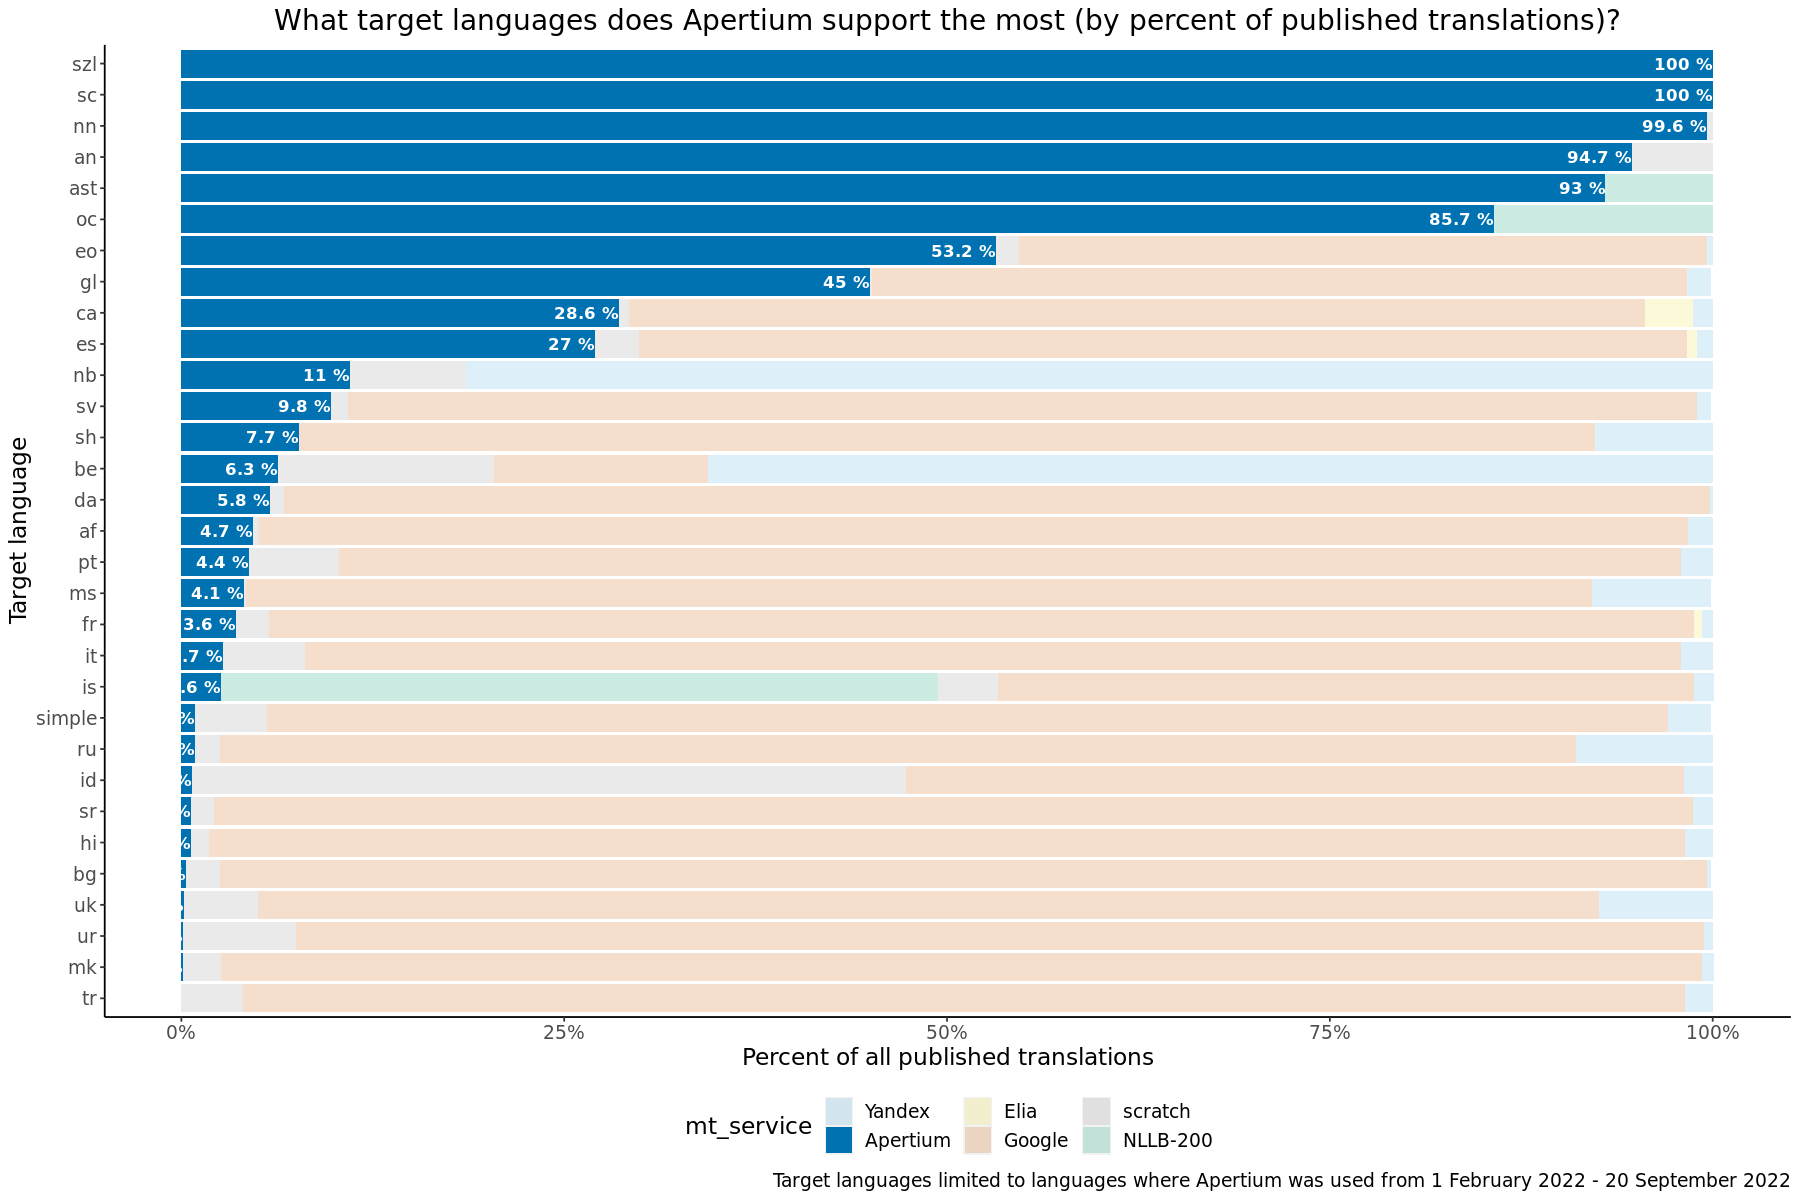

In [88]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- apertium_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'Apertium', paste(round(pct_translations * 100,2), "%"), " ")))  +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'Apertium'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.2), guide = F) +
        geom_text(size = 3.5, fontface = "bold", color = 'white', hjust = 1) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does Apertium support the most (by percent of published translations)?",
            caption = "Target languages limited to languages where Apertium was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.2,1,0.2, 0.2, 0.2, 0.2)))) +
         scale_fill_manual(values = c( "#56B4E9","#0072B2", "#F0E442" ,"#D55E00","#999999","#009E73" )) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/apertium_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

**Most popular target languages:**

* Apertium has been used for 100% of published translations (excluding any translations that did not use a service [scratch]) at the following target languages: Silesian (szl), Sardinian (sc), Norwegian (Nynorsk) (nn), and Aragonese (an), where it was the only used service or default service at language pairs for these target languages.
* There have been some decreases in the use of Apertium at target languages where available due to the change in default services from Apertium to other machine translation services as part of a change deployed in June 2022. For example, Catalan (ca) translations with Apertium have decreased from 38.8% to 28.6%.


### Elia (formerly know as Matxin)

Elia was primarily created by for writing Wikipedia articles in Basque and Spanish and has only been used to translate 1.2% of published translation across all target langugages.  You can find more details on the [Elia mediawiki page](https://www.mediawiki.org/wiki/Content_translation/Machine_Translation/Matxin?useskin=vector-2022).


In [89]:
# list of languages where Elia was used in language pairs
elia_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'Elia']

In [90]:
# restrict to usage of Elia in different langauges where available
elia_data <- mt_service_compare %>%
    filter(target_language %in% elia_languages)  

In [91]:
# Compare usage
elia_usage_compare <- elia_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [92]:
# order target languages based on factor levels

lvls <- as.character(elia_usage_compare$target_language[elia_usage_compare$mt_service=="Elia"])[order(elia_usage_compare$pct_translations[elia_usage_compare$mt_service=="Elia"])]
elia_usage_compare$target_language <- factor(elia_usage_compare$target_language,levels=lvls)

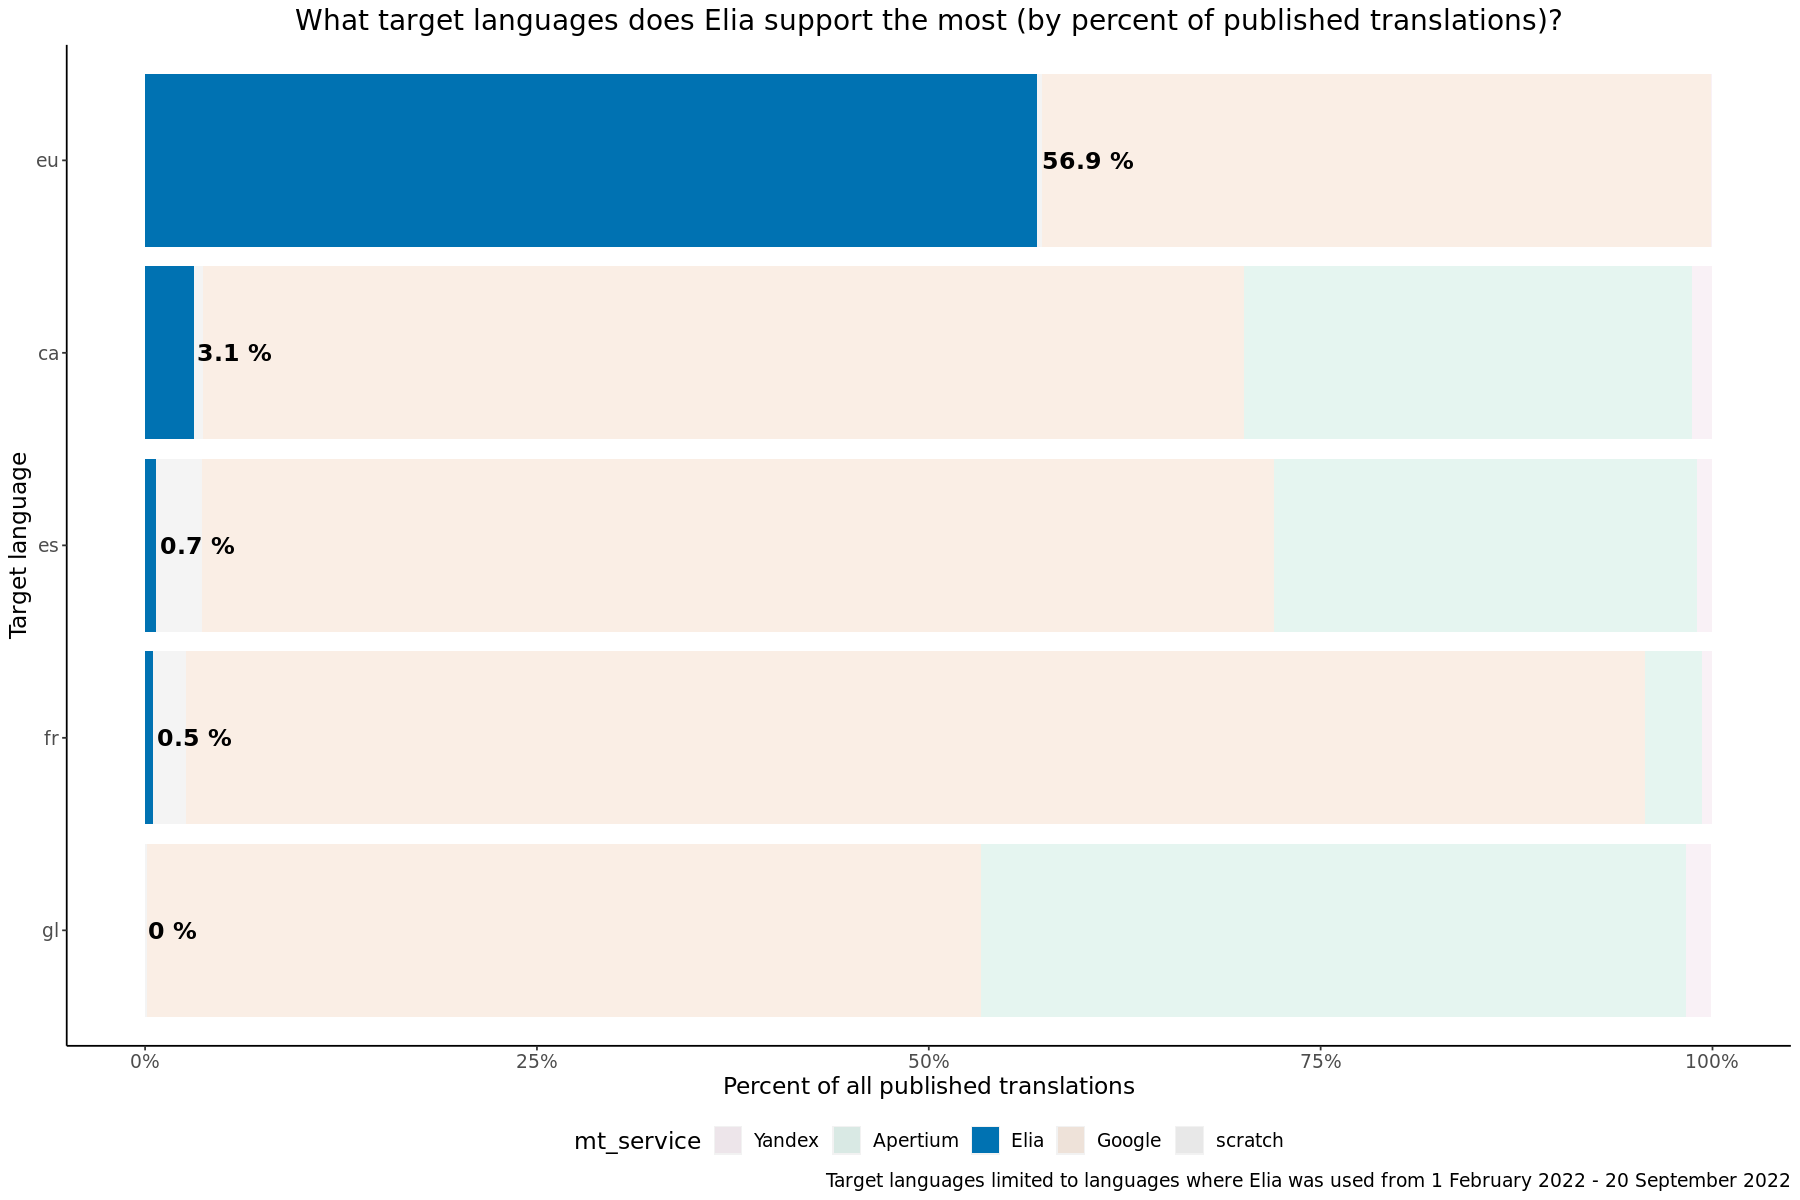

In [93]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- elia_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'Elia', paste(round(pct_translations * 100,2), "%"), " "))) +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'Elia'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.1), guide = F) +
        geom_text(size = 5, fontface = "bold", color = 'black', hjust = -0.05) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does Elia support the most (by percent of published translations)?",
              caption = "Target languages limited to languages where Elia was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.1,0.1,1, 0.1, 0.1)))) +
         scale_fill_manual(values = c( "#CC79A7", "#009E73", "#0072B2","#D55E00",  "#999999" )) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/elia_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

**Most popular target languages:**

* Elia is most frequently used at the Basque (eu) target language, where it is used for 56.9% of published translations at this target language (A 32% increase from the overall usage identified in the first report). This increase is likely due to a change in June 2022 that made Elia the default service for several language pairs.
* Elia usage increased following it's deployment as a default service at the following language pairs: 
  * en-eu: Elia usage increased from 29.8% to 36.6%
  * fr-eu: Elia usage increased from 29% to 43%
  * gl-eu: Elia usage increased from 25% to 53.8%
  * es-eu:Elia usage increased from 52.3% to 69%
* Catalan (ca) is the second most supported target language by Elia. 3.1% of all published translations at Catalan are created using Elia.
* Elia is used for under 1% of published translations at Spanish (es), French (fr), and Galician (gl) target languages.



### NLLB-200 (formerly known as Flores)

NLLB-200  was recently deployed as a machine translation service in February 2022 and has been used to translate 6.05% of all published translations since it become available. NLLB-200  can currently be used to translate from English to Chinese, Icelandic, Hausa, Zulu, Igbo, Occitan, and Luganda. In addition to this report, a separate analysis on NLLB-200  usage was done in this [report](https://github.com/wikimedia-research/machine-translation-service-analysis-2022/blob/main/flores_usage_analysis.ipynb)

You can find more details on the [NLLB-200 mediawiki page](https://www.mediawiki.org/wiki/Content_translation/Machine_Translation/Flores?useskin=vector-2022).

In [94]:
# list of languages where Flores was used in language pairs
flores_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'NLLB-200']

In [95]:
# restrict to usage of Flores in different langauges where available
flores_data <- mt_service_compare %>%
    filter(target_language %in% flores_languages)  

In [96]:
# Compare usage
flores_usage_compare <- flores_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [97]:
# order target languages based on factor levels

lvls <- as.character(flores_usage_compare$target_language[flores_usage_compare$mt_service=="NLLB-200"])[order(flores_usage_compare$pct_translations[flores_usage_compare$mt_service=="NLLB-200"])]
flores_usage_compare$target_language <- factor(flores_usage_compare$target_language,levels=lvls)

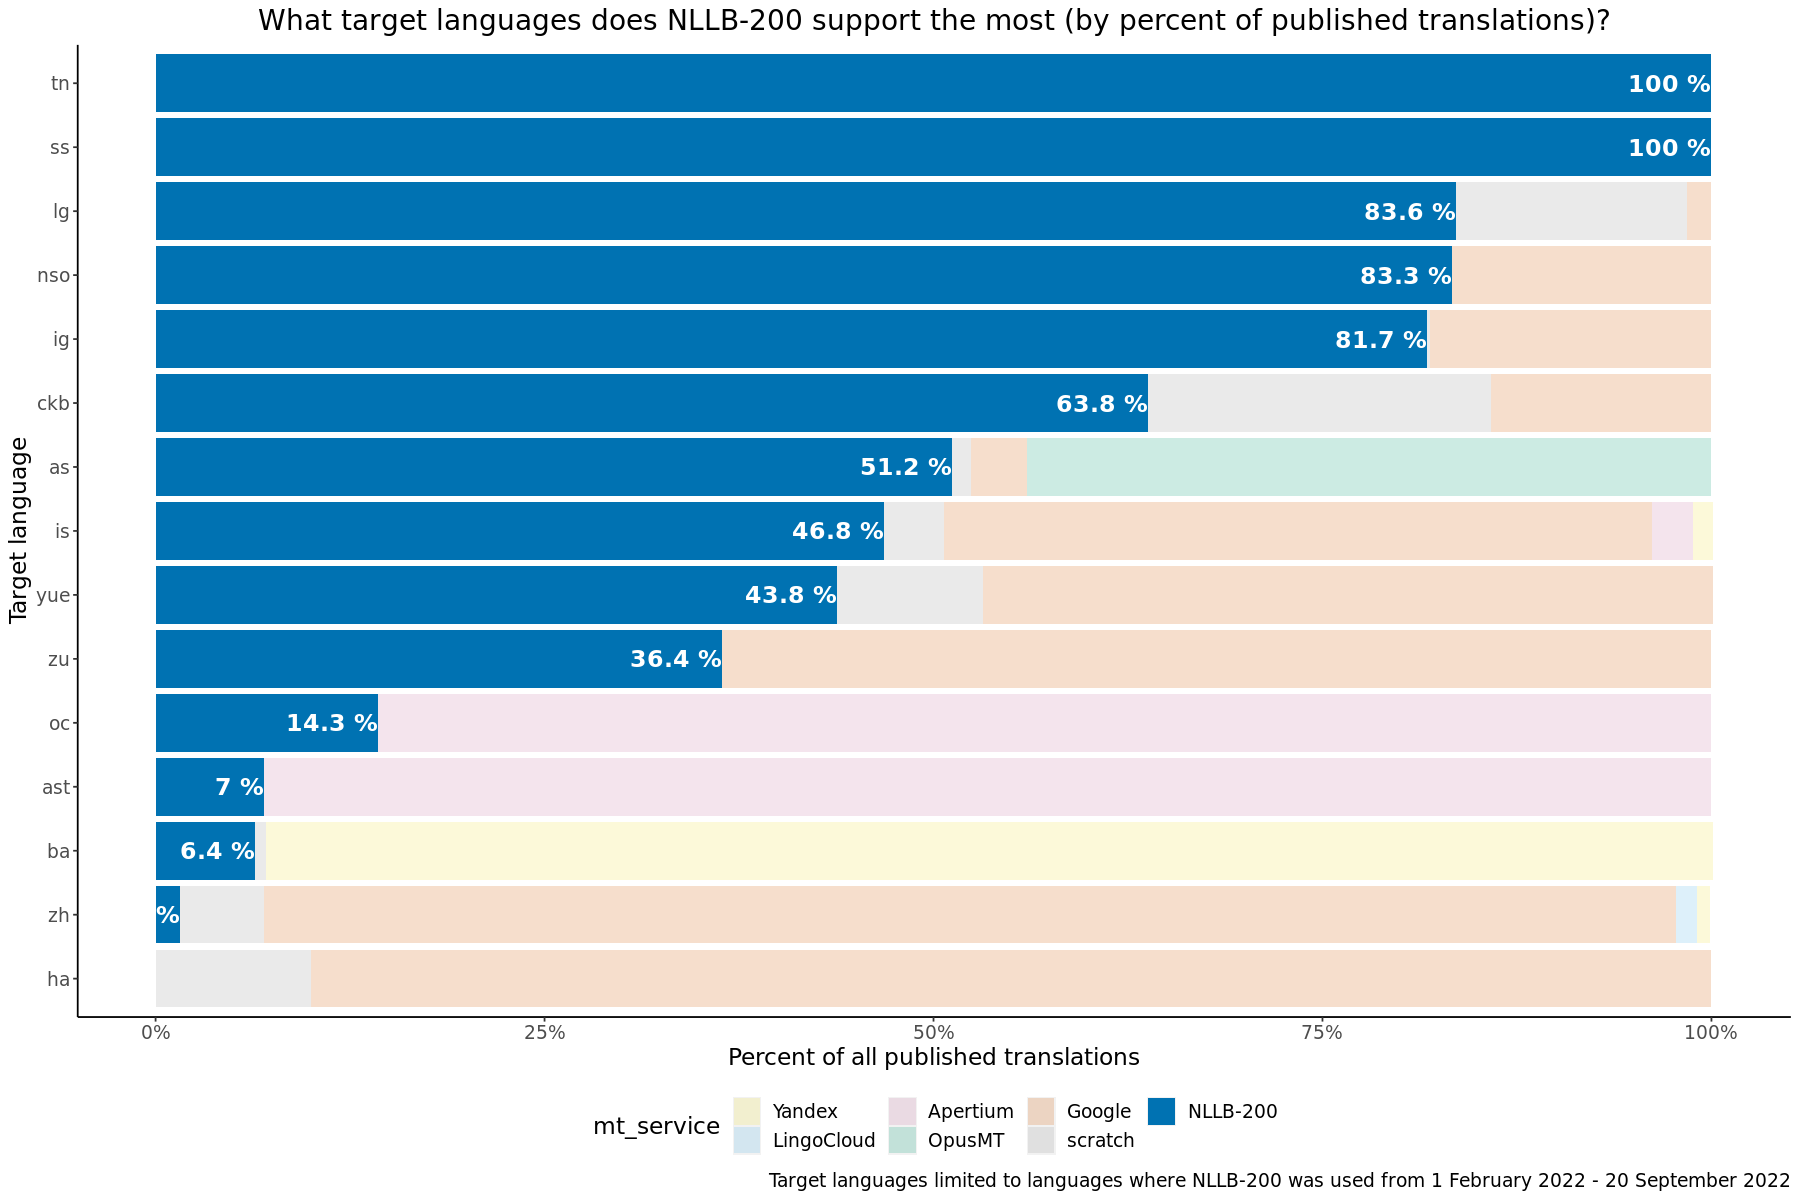

In [98]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- flores_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'NLLB-200', paste(round(pct_translations * 100,2), "%"), " "))) +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'NLLB-200'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.2), guide = F) +
        geom_text(size = 5, fontface = "bold", color = 'white', hjust = 1) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does NLLB-200 support the most (by percent of published translations)?",
              caption = "Target languages limited to languages where NLLB-200 was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.2,0.2, 0.2, 0.2, 0.2, 0.2, 1)))) +
         scale_fill_manual(values = c("#F0E442", "#56B4E9","#CC79A7",  "#009E73","#D55E00", "#999999",  "#0072B2" )) + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            


ggsave("Figures/flores_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p

**Most popular target languages:**

* NLLB-200 was made available to additional target languages in June 2022. 
* Since then, the service has been used for 100% of translations at Tswana(tn) [10 translations] and Swati(ss) [11 translations] target languages.
* There is also high usage now at Northern Sotho (nso) and Soran (ckb) target languages.
* The usage of NLLB-200 has increased significantly at Igbo (ig) since made available to additional language pairs.  14.7% of publications in the May 2022 report to 81.7% of publications in the September 2022 report.
* There have been slight increases for Occitan (oc) and Luganda (Lg) where the service has also been made available at additional language pairs in June 2022.

### Opus MT

OpusMT is an open source machine translation system that is currently only available to support translations from English to Assamese (as), Central Bicolano (bcl) and Tsonga (ts) target languages. It has been used to publish 0.15% of all published translations since February 2022. 
 

In [99]:
# list of languages where Opus was used in language pairs
opus_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'OpusMT']

In [100]:
# restrict to usage of Flores in different langauges where available
opus_data <- mt_service_compare %>%
    filter(target_language %in% opus_languages) 

In [101]:
# Compare usage
opus_usage_compare <- opus_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) 

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [102]:
# order target languages based on factor levels

lvls <- as.character(opus_usage_compare$target_language[opus_usage_compare$mt_service=="OpusMT"])[order(opus_usage_compare$pct_translations[opus_usage_compare$mt_service=="OpusMT"])]
opus_usage_compare$target_language <- factor(opus_usage_compare$target_language,levels=lvls)

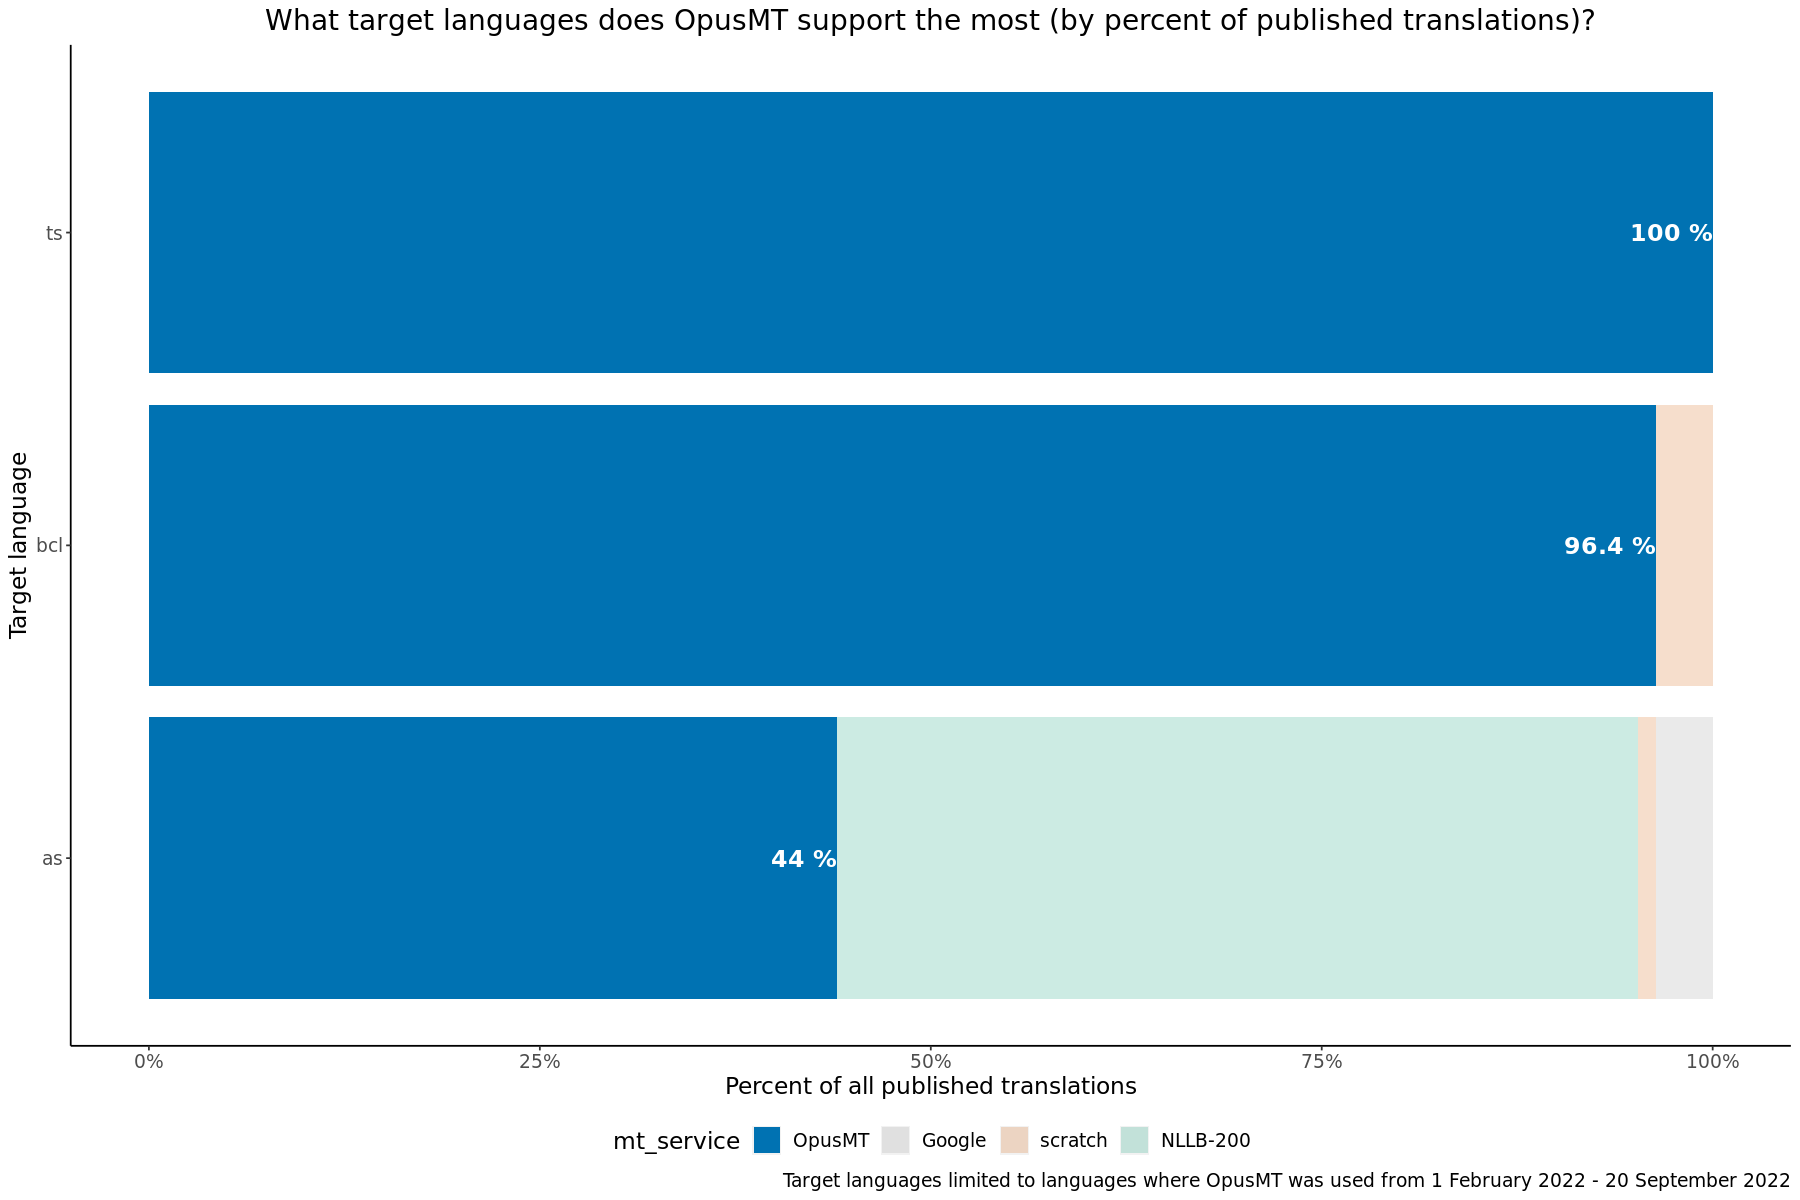

In [103]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- opus_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'OpusMT', paste(round(pct_translations * 100,2), "%"), " "))) +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'OpusMT'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.2), guide = F) +
        geom_text(size = 5, fontface = "bold", color = 'white', hjust = 1) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does OpusMT support the most (by percent of published translations)?",
              caption = "Target languages limited to languages where OpusMT was used from 1 February 2022 - 20 September 2022"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(1,0.2, 0.2, 0.2)))) +
         scale_fill_manual(values = c( "#0072B2", "#999999", "#D55E00", "#009E73" )) + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

ggsave("Figures/opusMt_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p

**Most popular target languages:**

* OpusMT has only been used to publish translations at Assamese (as), Central Bicolano (bcl), and Tsonga (ts)  target languages. 
* A little under half of translations at  Assamese (as) (44%) are completed using OpusMT as of September 2022 compared to 100% of publications in May 2022. 53% of translations for this target language were completed using NLLB-200. NLLB-200 was deployed to this Wikipedia in June 2022.



### Google Translate

Google Translate is the most frequently used machine translation service (used for 81.7% of all published translations) and supports about 100 languages. 

You can find more details on the [Google Translate mediawiki page](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Google_Translate&useskin=vector-2022).


In [104]:
# list of languages where Google Translate was used in language pairs
google_languages = mt_service_compare$target_language[mt_service_compare$mt_service == 'Google']

In [105]:
# restrict to usage of Elia in different langauges where available
google_data <- mt_service_compare %>%
    filter(target_language %in% google_languages)  

In [106]:
# Compare usage
google_usage_compare <- google_data %>%
    group_by(target_language, mt_service) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3)) %>%
    filter(pct_translations != 1) #filter out language pairs where Google Translate usage was 100%

`summarise()` regrouping output by 'target_language' (override with `.groups` argument)



In [107]:
# order target languages based on factor levels

lvls <- as.character(google_usage_compare$target_language[google_usage_compare$mt_service=="Google"])[order(google_usage_compare$pct_translations[google_usage_compare$mt_service=="Google"])]
google_usage_compare$target_language <- factor(google_usage_compare$target_language,levels=lvls)

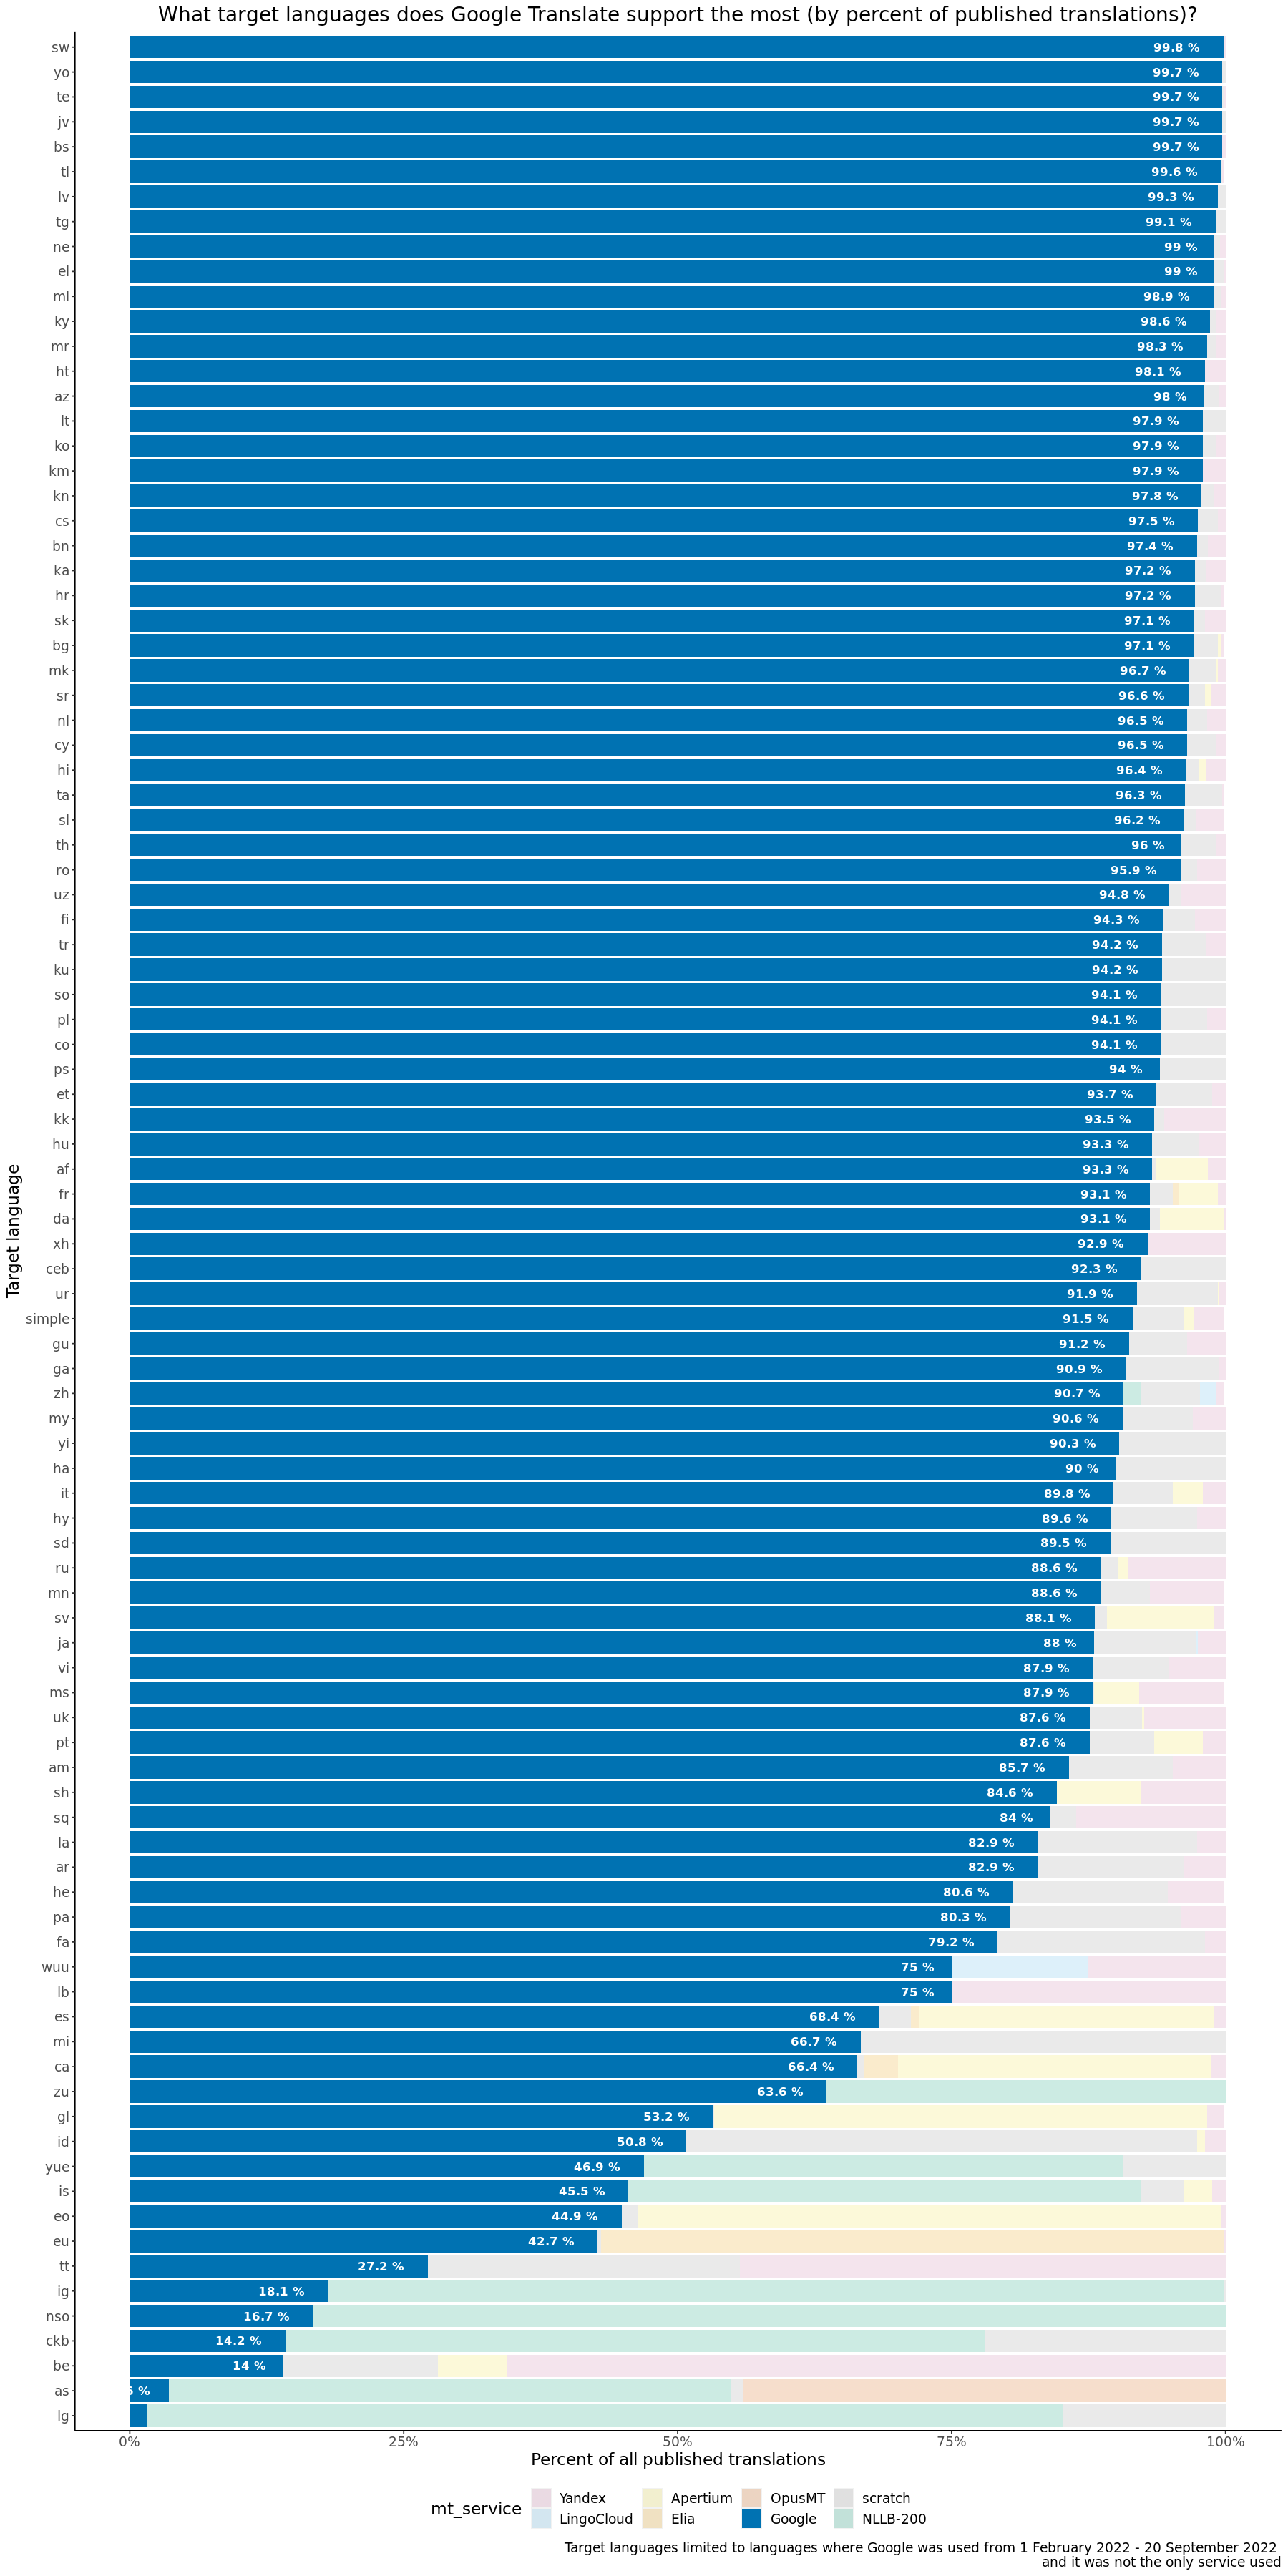

In [108]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 30)

p <- google_usage_compare %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = ifelse(mt_service == 'Google', paste(round(pct_translations * 100,2), "%"), " ")))  +
        coord_flip() +
       geom_bar(aes(alpha = mt_service == 'Google'), stat = 'identity') +
       scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.2), guide = F) +
        geom_text(size = 3.5, fontface = "bold", color = 'white', hjust = 1.5) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "What target languages does Google Translate support the most (by percent of published translations)?",
            caption = "Target languages limited to languages where Google was used from 1 February 2022 - 20 September 2022 \n and it was not the only service used"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c( 0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2)))) +
         scale_fill_manual(values = c( "#CC79A7",  "#56B4E9", "#F0E442", "#E69F00",  "#D55E00", "#0072B2", "#999999","#009E73" )) +
         theme( 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

ggsave("Figures/google_usage_compare.png", p, width = 16, height = 8, units = "in", dpi = 300)
p
    

**Most popular target languages:**
* Google Translate was used to translate 100% of translations at many target languages including languages where it is the default or only available service. For the purpose of clarity, the above chart focuses on target languages where other MT services were available and used in addition to Google Translate.
* Excluding target languages where Google Translate is used for 100% of translations:  
  * It is used for over 50% of published translations at over 72 different target languages where other services are offered as well.
  * There has been an increase in use of Google Translate since it has been used as Google translate was deployed to more languages on 27 July 2022 in [T308248](https://phabricator.wikimedia.org/T308248). 
  * There have also been some decreases in usage at target languages where Google was removed as the default setting. For example, Google Translate was used for 42.7% of publications at Basque (eu) compared to 56.4% of publications indicated in the May 2022 report. 
* Google was changed to the default machine translation service for several language pairs in June 2022 as part of [T309266](https://phabricator.wikimedia.org/T309266). The following increases were identified following this change:
  * pt-gl: Google usage increased from 57.6% to 79.8%.
  * en-es: Google usage increased from 51.8% to 66.3%.
  * en-ca: Google usage increased from 66.3% to 81%.
  * fr-ca: Google usage increased from 61% to 75.8%.
  * it-ca: Google usage increased from 56% to 73.4%.
  


# Percent machine translation content is modified

The content provided by each machine translation service can be modified by the user before publishing. We track the percent each translation is modified by the user. Per the MT abuse calculation [documentation](https://github.com/wikimedia/mediawiki-extensions-ContentTranslation/blob/master/doc/MTAbuseCalculation.md), a warning or error is shown to user depending on how much unmodified content is present. This encourages the user to edit it further. In some cases users are still able to publish, but the resulting page may get added to a tracking category of potentially unreviewed translations for the community to review. In other cases, users may not be allowed to publish.

For the purpose of this analysis, we limited the analysis to only published translations and reviewed the percent the machine translation content was modified by users into three categories: less than 10%, between 10 and 50%, and over 50%. These categories can be adjusted as needed. 

**Method**: Data on percent each translation is modified comes from the `translations_progress` field [^Note] in the cx_translation table (as indicated by the `human` percentage stat). 

[^Note]: The translations_progress data shows the percentage of translation completion. human indicates manual translation percentage. mt indicates machine translation percentage. Any edits to machine translation output are considered as manual edits. The percentages are calculated at section level. any indicates the total translation (any=human+mt). Content Translation does not demand full translation of the source article.

In [110]:
# modifications by percent modified

mt_modification <- mt_service_compare %>% 
    filter(mt_service != 'scratch') %>% #review only MT service modifications
    mutate(pct_human_modified = case_when(
        human_translated_percent < 0.10  ~ "less than 10%",
         (human_translated_percent >= 0.10 &  human_translated_percent < 0.51) ~ "between 10 and 50%",
         human_translated_percent >= 0.51  ~  "over 50%"),
          pct_human_modified = factor(pct_human_modified, 
                                        levels=c("over 50%", "between 10 and 50%", "less than 10%")),
          mt_service = factor(mt_service,
                             levels = c('NLLB-200', 'OpusMT', 'Elia', 'Google', 'Yandex', 'Apertium', 'LingoCloud')))

### Overall

In [111]:
# find percent mt modified by languages where target language is available
mt_modification_byservice <- mt_modification %>%
    group_by(mt_service, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3))
    


`summarise()` regrouping output by 'mt_service' (override with `.groups` argument)



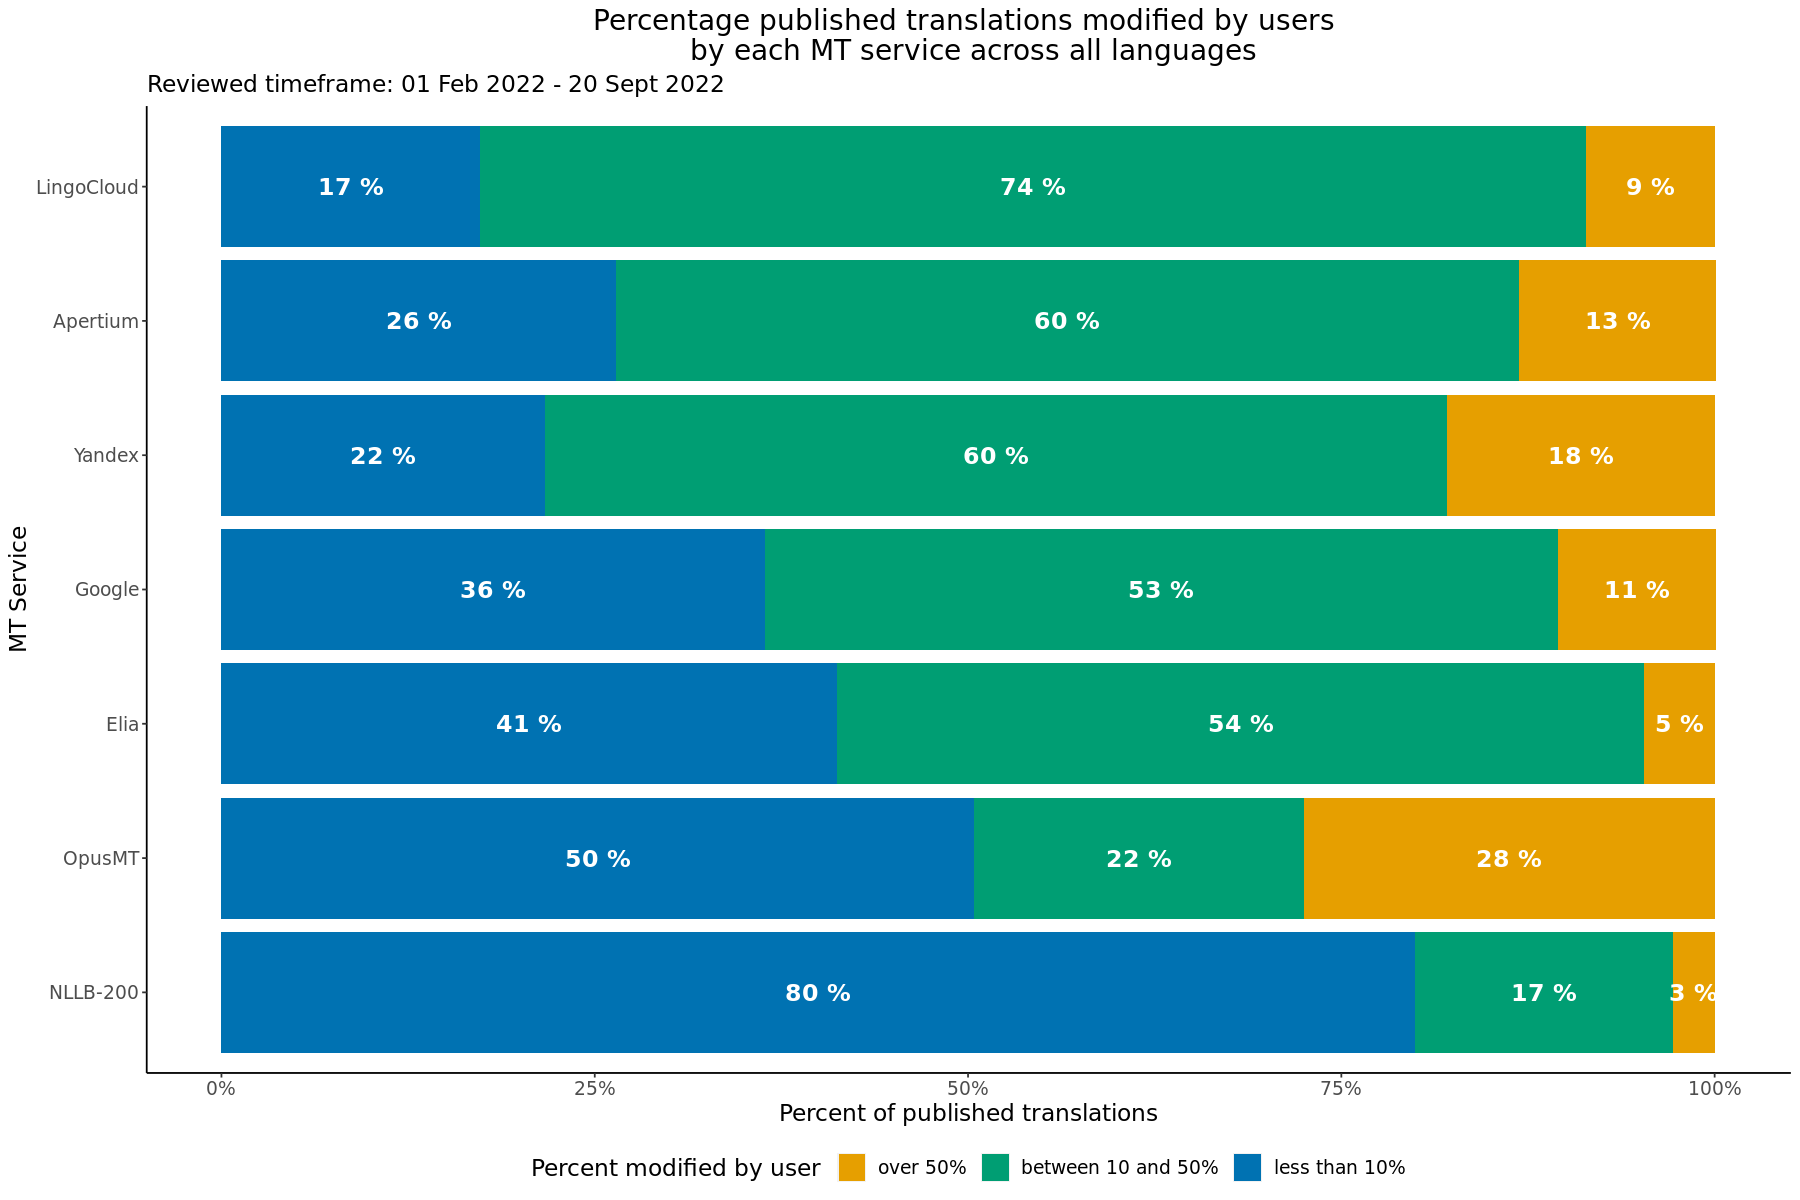

In [113]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- mt_modification_byservice  %>%
        ggplot(aes(x = mt_service, y= pct_translations, fill = pct_human_modified,
                  label = paste(round(pct_translations * 100,0), "%")) ) +
        geom_bar(stat = 'identity') +
        coord_flip() +
         geom_text(size = 5, color = 'white', fontface = 'bold', position = position_stack(vjust = 0.5)) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "MT Service",
              y = "Percent of published translations",
             title = "Percentage published translations modified by users \n by each MT service across all languages",
              subtitle = "Reviewed timeframe: 01 Feb 2022 - 20 Sept 2022"
             ) +
         scale_fill_manual(values = c("#E69F00", "#009E73", "#0072B2")) +
        guides(fill=guide_legend(title="Percent modified by user")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/ mt_modification_byservice .png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p
            

For all translations published from 1 February 2022 through 20 September 2022:
* The majority of publications by each MT service are modified over 10% by the user with the exception of OpusMT and NLLB-200.
* NLLB-200 has a higher percentage of slightly modified translations compared to the other services. 80% of NLLB-200 translations are modified by users less than 10%, compared to 50% or less for the other MT services.
* LingoCloud has the lowest percent of publications modified less than 10%. Content provided by this machine translation service is typically modified between 10 and 50% (74% of all publications). 
*  OpusMT has the highest percent of translations modified over 50% (28% of publications).

However, each of these machine translations services are available at differing sets and numbers of language pairs. For example, NLLB-200 and OpusMT are only available at a small set of language pairs while Google Translate and Yandex are offered at a larger set of language pairs. 

To determine the impact of language pair availability, we reviewed percent modifications by each MT service across shared sets of supported languages and by each target language, starting with a look at only NLLB-200 supported languages. 

### NLLB supported languages

In [114]:
# find percent mt modified by languages at only flores supported languages
flores_mt_modification <- mt_modification %>%
     filter(target_language %in% c('asm', 'ast', 'ayr', 'bak', 'ckb', 'hau', 'ibo', 'ilo', 'isl',
                                   'kon', 'lin', 'lug', 'oci',
                                   'nso', 'orm', 'ssw', 'tir', 'tsn', 'tso', 'yue', 'wol', 'yue', 
                                   'zho_Hans', 'zul', 'ig','is', 'lg', 'oc', 'zh', 'zu'
                                  ),
          source_language %in% c('en', 'ca', 'es', 'fr', 'ru' , 'zh', 'rus', 'zho_Hans', 'cat', 'por'))  %>%  
    group_by(mt_service, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3))


`summarise()` regrouping output by 'mt_service' (override with `.groups` argument)



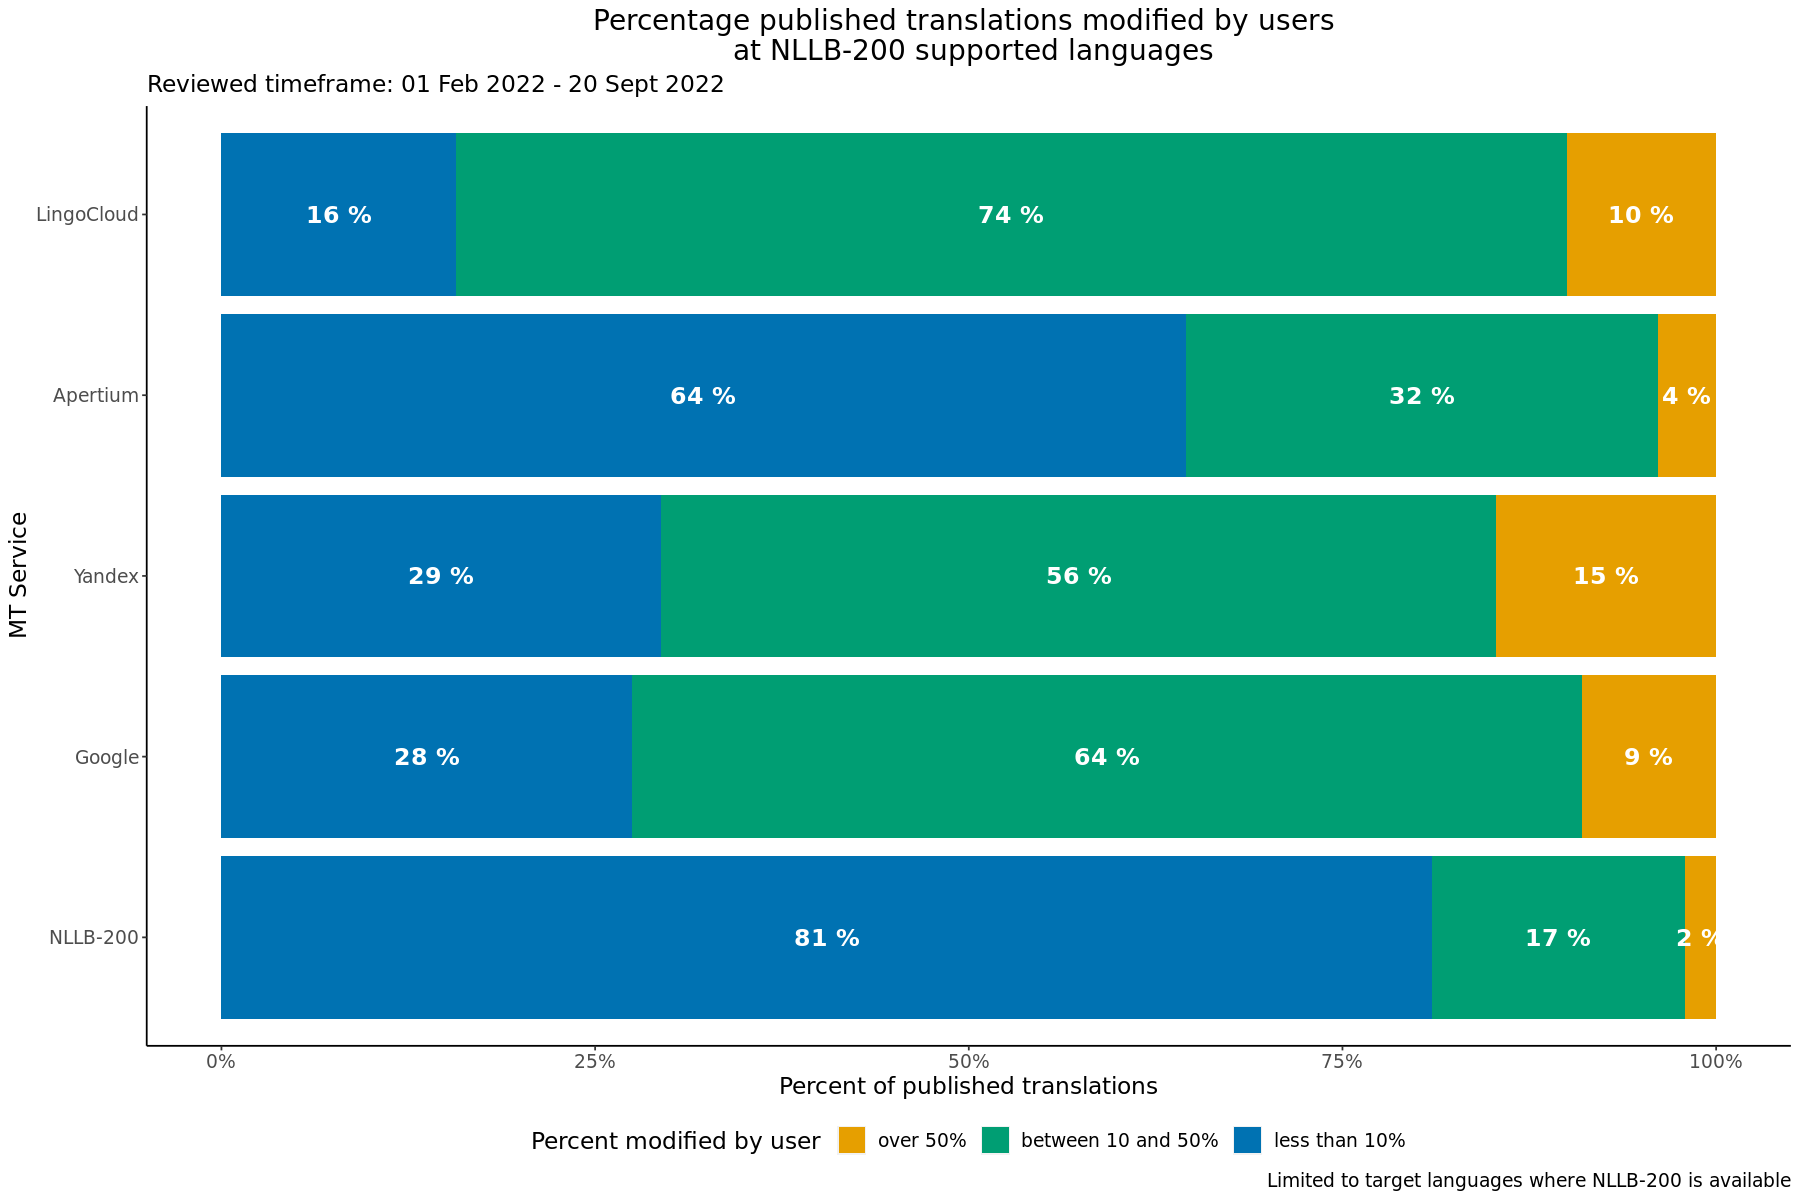

In [274]:
# Chart usage compared to other services

options(repr.plot.width = 15, repr.plot.height = 10)

p <- flores_mt_modification  %>%
        ggplot(aes(x = mt_service, y= pct_translations, fill = pct_human_modified,
                  label = paste(round(pct_translations * 100,0), "%")) ) +
        geom_bar(stat = 'identity') +
        coord_flip() +
         geom_text(size = 5, color = 'white', fontface = 'bold', position = position_stack(vjust = 0.5)) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "MT Service",
              y = "Percent of published translations",
             title = "Percentage published translations modified by users \n at NLLB-200 supported languages",
              subtitle = "Reviewed timeframe: 01 Feb 2022 - 20 Sept 2022",
              caption = "Limited to target languages where NLLB-200 is available"
             ) +
         scale_fill_manual(values = c("#E69F00", "#009E73", "#0072B2")) +
         guides(fill=guide_legend(title="Percent modified by user")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/ flores_mt_modification.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p

**Key Findings**
When limited to just NLLB-200 supported language pairs, we observed the following differences in percent modification rates:
* No significant changes in percent modification rates with LingoCloud and Yandex.
* There was a significant increase in the percent of slightly modified translations for Apertium (26% overall to 64% at NLLB-supported languages).
* There was a decrease in the percent of slightly modified translations for Google (36% overall to 28% at NLLB-supported languages).

However, these results can be largely skewed by one specific language at instances where the majority of translations for a machine translation service have been done at one language pair. We further reviewed usage at each NLLB-200 supported target language to determine if these observed differences are more due to the target language or the machine translation service.

In [116]:
# find percent mt modified by languages at only NLLB-200 supported languages by target
flores_mt_modification_bytarget <- mt_modification %>%
      filter(target_language %in% c('asm', 'ast', 'ayr', 'bak', 'ckb', 'hau', 'ibo', 'ilo', 'isl',
                                   'kon', 'lin', 'lug', 'oci',
                                   'nso', 'orm', 'ssw', 'tir', 'tsn', 'tso', 'yue', 'wol', 'yue', 
                                   'zho_Hans', 'zul', 'ig','is', 'lg', 'oc', 'zh', 'zu'
                                  ),
          source_language %in% c('en', 'ca', 'es', 'fr', 'ru' , 'zh', 'rus', 'zho_Hans', 'cat', 'por')) %>%
    mutate(target_language = factor(target_language, 
                            levels = c('oc', 'as', 'ast', 'ba', 'ckb', 'ha', 'ig', 'is', 'lg', 'nso', 'ss', 'tn' , 'yue', 'zh', 'zu'),
                            labels = c('Occitan', 'Assamese' , 'Asturian','Bashkir' , 'Sorani', 'Hausa', 'Igbo', 'Icelandic', 'Luganda', 'Northern Sotho', 'Swati',
                                      'Tswana', 'Cantanese' , 'Chinese', 'Zulu')))  %>%
    group_by(mt_service, target_language, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3))

`summarise()` regrouping output by 'mt_service', 'target_language' (override with `.groups` argument)



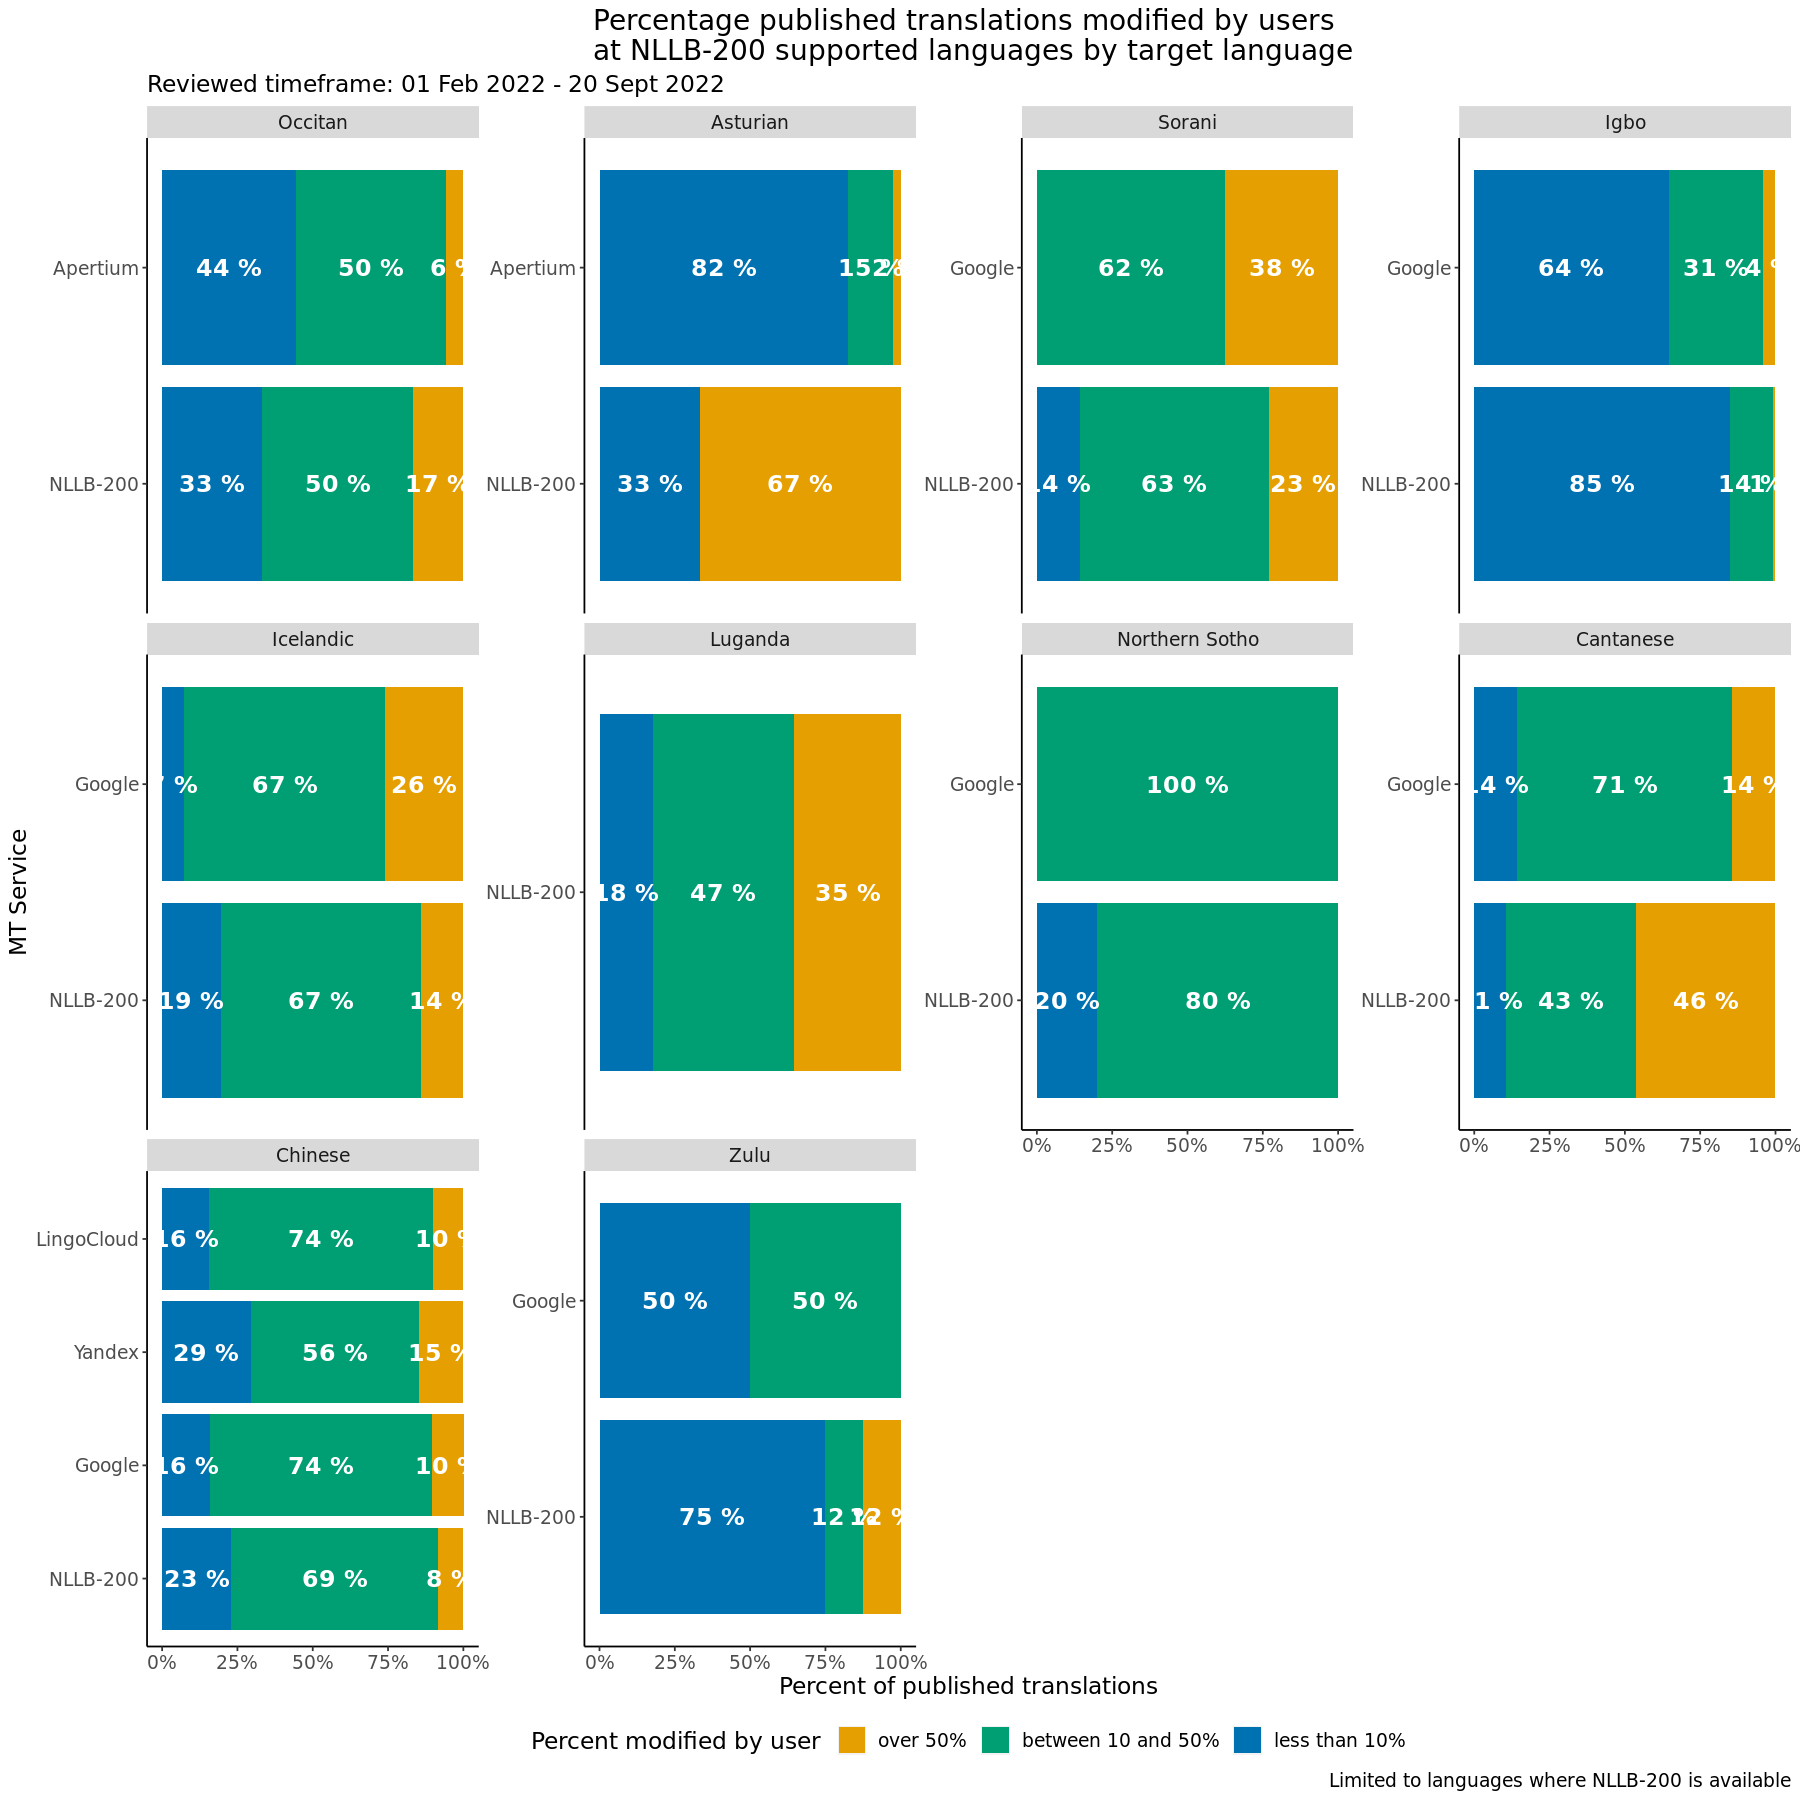

In [275]:
# Chart usage compared to other services by target

options(repr.plot.width = 15, repr.plot.height = 15)

p <- flores_mt_modification_bytarget %>%
        ggplot(aes(x = mt_service, y= pct_translations, fill = pct_human_modified,
                  label = paste(round(pct_translations * 100,0), "%")) ) +
        geom_bar(stat = 'identity') +
        coord_flip() +
         geom_text(size = 5, color = 'white', fontface = 'bold', position = position_stack(vjust = 0.5)) +
        facet_wrap(~target_language, scales = "free_y") +
        scale_y_continuous(labels = scales::percent) +
        scale_x_discrete() +
        labs (x = "MT Service",
              y = "Percent of published translations",
             title = "Percentage published translations modified by users \n at NLLB-200 supported languages by target language",
              caption = "Limited to languages where NLLB-200 is available",
              subtitle = "Reviewed timeframe: 01 Feb 2022 - 20 Sept 2022"
             ) +
         scale_fill_manual(values = c("#E69F00", "#009E73", "#0072B2")) +
         guides(fill=guide_legend(title="Percent modified by user")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/flores_mt_modification_bytarget.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p

**Key Findings**
Based on a breakdown by target language, we see a clearer impact of the target language on the differences in modification rates.

* The high percentage of slightly modified translations using NLLB-200 are primarily due to translations for the Igbo and Zulu target languages, where over 75% translations at Zulu and 85% translations at Igo were modified less than 10% . Both of these target languages also have higher percent of slightly modified translations using Google compared to the overall rates.
* We also observed that the percent each machine translation service is typically modified can vary across target languages. The percent modification rates using Google ranges from 14% slightly modified for the Cantonese target language to 64% for Igbo. 



# Percent of articles that are created with each MT service and deleted

We also reviewed the percent of articles created with each MT service that were deleted as an indicator of quality. This was reviewed alongside the modification data to determine if a high number of translations only slightly modified is indicative of good machine translation service quality or a sign that these articles have not been edited enough.

**Method**: Data comes from mediawiki_history and reflects the deletion ratios of main namespace articles that were created using Content Translation compared to the deletion ratios of main namespace articles created without the tool. Bots were excluded.

Notes:
* Data summarized below reflects articles and created from 1 February 2022 through 20 September 2022. It's possible some of the articles created during this timeframe may still be deleted pending additional review time. 
* Details on deletion ratio for each wiki and machine translation service can also be found in the [google spreadsheet](https://docs.google.com/spreadsheets/d/1qLNWAnofzxOAfbvqLJBKmyh2chMz9Y8zwybFDqemWpc/edit#gid=1573305939) under the "deletion_ratios_bymt_andwiki" table.


In [118]:
# load data
mt_deletion_data <-
  read.csv(
    file = 'Data/mt_deletion_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all cx data

In [119]:
# replace NA values with 0
mt_deletion_data[is.na(mt_deletion_data)] <- 0

## Overall 

In [120]:
mt_deletion_overall <- mt_deletion_data %>%
    group_by(mt_service) %>%
    summarise(total_deleted = sum(deleted_cx_total),
              total_created = sum(created_cx_total),
              pct_deleted = paste0(round(total_deleted/total_created * 100, 2), "%"))


`summarise()` ungrouping output (override with `.groups` argument)



In [198]:
## find all translation modified less than 10 to supplement data
less_than_10 = 
mt_modification_byservice[which(mt_modification_byservice$pct_human_modified == "less than 10%"),] %>%
    select(c(1,4))

# Join with deletion data
mt_deletion_overall_mod <- merge(x = mt_deletion_overall, y = less_than_10, by = "mt_service", all = TRUE) %>%
mutate(pct_translations = paste0(round(pct_translations * 100, 2), "%"))

#rename column
names(mt_deletion_overall_mod)[5] <- 'pct_modified_under10'


In [235]:
mt_deletion_overall_tbl <- mt_deletion_overall_mod %>%
  gt() %>%
  tab_header(
    title = "Articles created with content translation and deleted by Machine Translation Service",
    subtitle = "Reviewed Timeframe: 1 February 2022 - 20 September 2022"
  )  %>%
  cols_label(
    mt_service = "Machine Translation Service",
    total_deleted = "Number of Articles Deleted",
    total_created = "Number of Articles Created",
    pct_deleted = "Percent of articles created then deleted",
    pct_modified_under10 = "Percent of translations modified under 10%"
  )  %>%
    gtsave(
    "mt_deletion_overall_tbl.html", inline_css = TRUE)

IRdisplay::display_html(data = mt_deletion_overall_tbl, file = "mt_deletion_overall_tbl.html")




<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Articles created with content translation and deleted by Machine Translation Service 
 
 
 Reviewed Timeframe: 1 February 2022 - 20 September 2022 
 
 
 
 
 Machine Translation Service 
 Number of Articles Deleted 
 Number of Articles Created 
 Percent of articles created then deleted 
 Percent of translations modified under 10% 
 
 
 
 
 Apertium 
 4146 
 85075 
 4.87% 
 26.4% 
 
 
 Elia 
 47 
 29953 
 0.16% 
 41.2% 
 
 
 Google 
 84293 
 2243378 
 3.76% 
 36.4% 
 
 
 LingoCloud 
 40 
 413 
 9.69% 
 17.3% 
 
 
 NLLB-200 
 120 
 94348 
 0.13% 
 79.9% 
 
 
 OpusMT 
 20 
 3674 
 0.54% 
 50.4% 
 
 
 Yandex 
 2325 
 60025 
 3.87% 
 21.7%

Overall across all languages, NLLB-200 currently has the lowest percent of articles created with content translation than deleted (0.13%) compared to all other MT services available, while it has the highest percent of translations modified under 10%, indicating that the modifications rates for this machine translations service are a signal of good machine translation quality.

We also observed similar trends for Elia and Opus MT (high percent of slightly modified articles and low deletion rates).

Since trends may be impacted by the target language as well, we also reviewed the deletion ratios for languages supported by the same Machine Translation service.

## By Similar Target Languages

In [179]:
## Find deletion and under 10 modification rates by wiki
mt_modification_bywiki <- mt_modification %>%
    group_by(mt_service, target_language, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id)) %>%
    mutate(pct_translations = round(num_translations/sum(num_translations), 3))

# find all translation modified less than 10 to supplement data
less_than_10_bywiki = 
mt_modification_bywiki[which(mt_modification_bywiki$pct_human_modified == "less than 10%"),] %>%
    mutate(wiki = paste(target_language,"wiki", sep = ""))  %>%
    select(c(1, 5, 6))
    

#Join with deletion data
mt_deletion_bywiki_mod <- merge(x = mt_deletion_data, y = less_than_10_bywiki, 
                                by = c("mt_service", "wiki"), all = TRUE) %>%
mutate(pct_translations = round(pct_translations, 3))

#rename column
names(mt_deletion_bywiki_mod)[6] <- 'pct_modified_under10'

`summarise()` regrouping output by 'mt_service', 'target_language' (override with `.groups` argument)

Adding missing grouping variables: `target_language`



### NLLB-Supported Languages

In [261]:
nllb_supported_lang_deletion_ratios <- mt_deletion_bywiki_mod %>%
    # isolate to NLLB supported languages
 filter(wiki %in% c('hawwiki', 'ocwiki','snwiki','igwiki', 'zuwiki', 'tnwiki', 'bawiki',
                    'zhwiki' ,'aswiki', 'zh_yuewiki', 'iswiki', 'nsowiki', 'lgwiki',
                    'sswiki', 'bjnwiki', 'ckbwiki', 'papwiki', 'avwiki', 'astwiki', 'rwwiki'),
       created_cx_total > 100)  %>%  #limited to languages with over 100 translations to date
mutate(pct_deleted = round(deleted_cx_total/created_cx_total, 3),
      pct_modified_under10 = round(pct_modified_under10, 3)) %>% 
select(-c(5)) %>%
arrange(wiki)


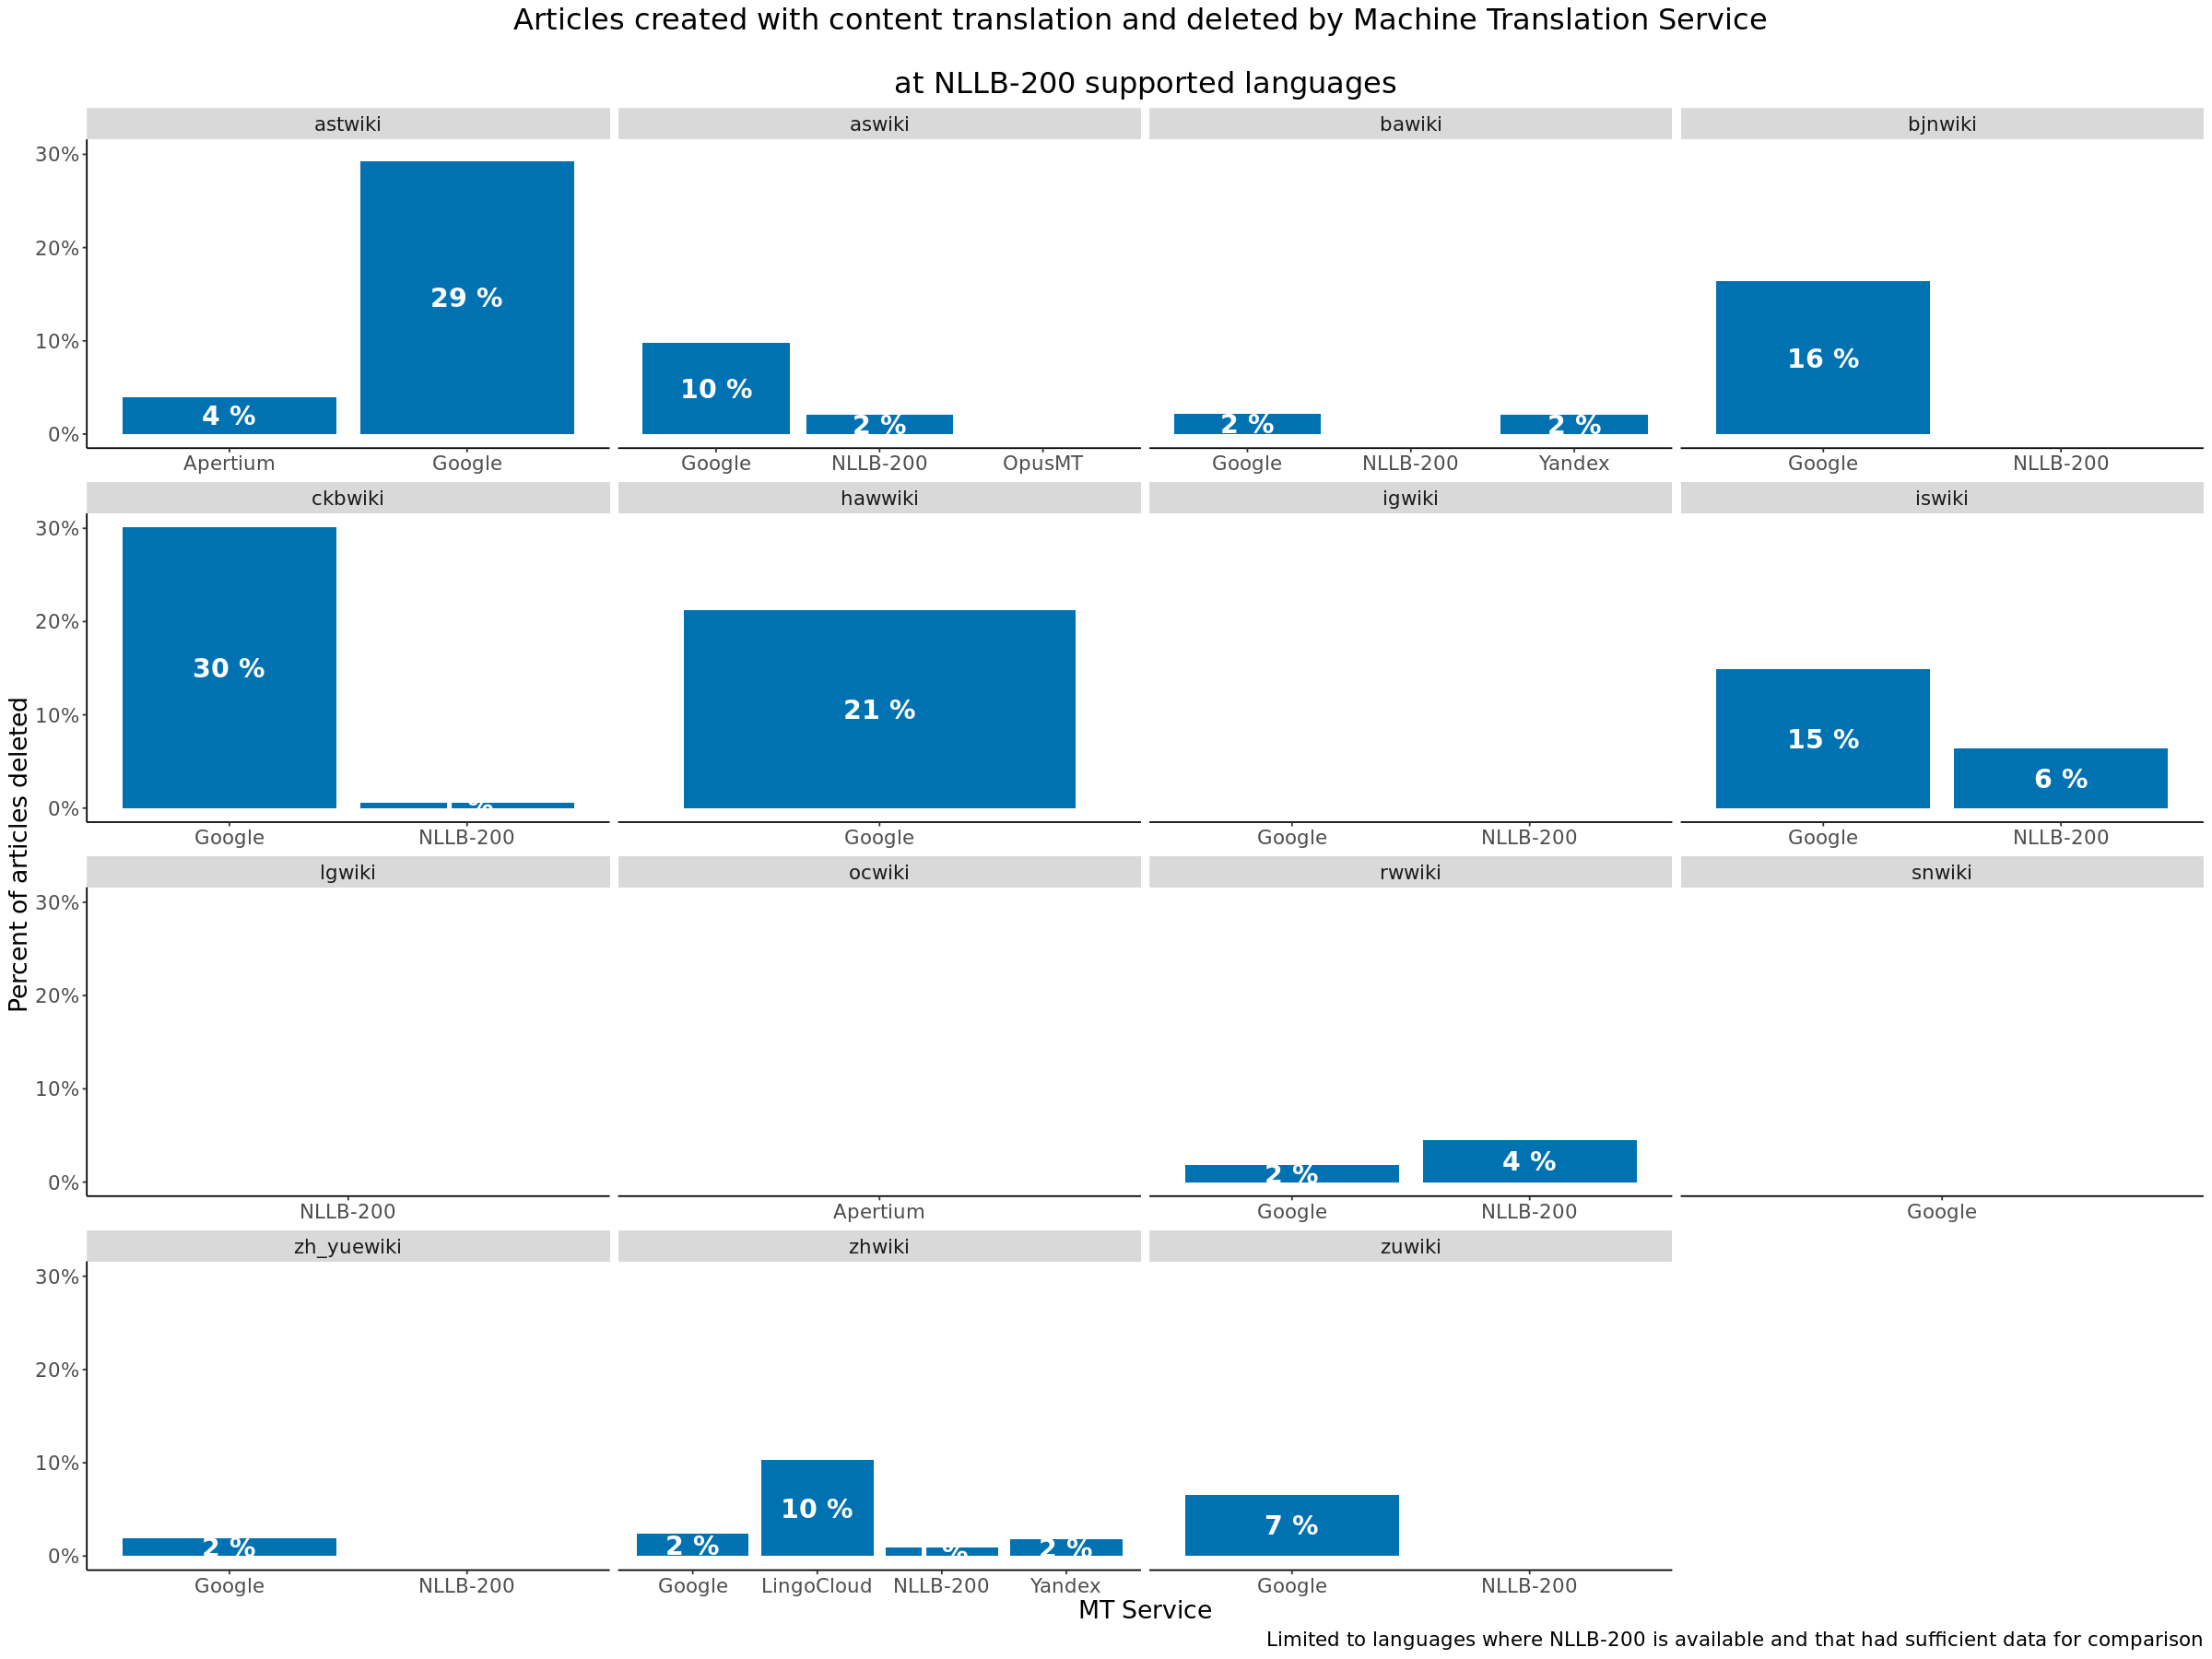

In [273]:
# Chart usage compared to other services

options(repr.plot.width = 20, repr.plot.height = 15)

p <- nllb_supported_lang_deletion_ratios %>%
        ggplot(aes(x = mt_service, y= pct_deleted,
                  label = paste(round(pct_deleted * 100,0), "%")) ) +
        geom_col(fill = '#0072B2') +
        #coord_flip() +
         geom_text(size = 6, color = 'white', fontface = 'bold', position = position_stack(vjust = 0.5)) +
        facet_wrap(~wiki,  scales = "free_x") +
        scale_y_continuous(labels = scales::percent) +
        scale_x_discrete() +
        labs (x = "MT Service",
              y = "Percent of articles deleted",
             title = "Articles created with content translation and deleted by Machine Translation Service \n
at NLLB-200 supported languages",
              caption = "Limited to languages where NLLB-200 is available and that had sufficient data for comparison"
             ) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/nllb_supported_lang_deletion_ratios.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p



There are varying deletion trends for the machine translation services at each NLLB-200 supported target language.

**Key Observations:**
* Articles created with LingoCloud at zhwiki were deleted more frequently (10%), compared to other available machine translation services on that Wikipedia.
* No articles created with content translation since 1 Feb 2022 have been deleted on the following NLLB-200 supported languages: igwiki, lgwiki, or ocwiki or snwiki. Igwiki was also found to have the highest rate of translations only slightly modified (under 10%) for all NLLB-200 supported languages. 
* Articles created using Google Translate have higher rates of deletion on astwiki (29%) and ckbwiki (30%) compared to other available machine translation services on those Wikis.

### Relationship between deletion rates and slightly modified rates [In progress]

The charts below provide a side by side comparison of the percent of articles deleted (shown in blue) and percent of translations modified under 10% (shown in yellow) at NLLB-200 supported languages to identify any relationship between these two metrics on a per language basis.

**Notes:**
* Analysis is currently limited to NLLB-200. Additional languages can be reviewed as needed. 
* Marking this section as in progress as I'm exploring different ways to best visualize this data. 

#### NLLB Supported Languages

In [279]:
nllb_supported_lang_bywiki_plot <- mt_deletion_bywiki_mod %>%
    # isolate to NLLB supported languages
 filter(wiki %in% c('ocwiki',  'zuwiki','bawiki','zhwiki','iswiki', 'nsowiki', 'lgwiki', 
                     'ckbwiki', 'papwiki', 'astwiki'),
       created_cx_total > 100) %>%  #limited to wikis with at least 100 translations) %>% 
    mutate(pct_deleted = round(deleted_cx_total/created_cx_total, 3))  %>% 
    gather(key = "metric", value = "percent", c( pct_modified_under10, pct_deleted)) %>% 
    filter(percent != 'NA' | percent != '0') #help focus on wikis where data was logged


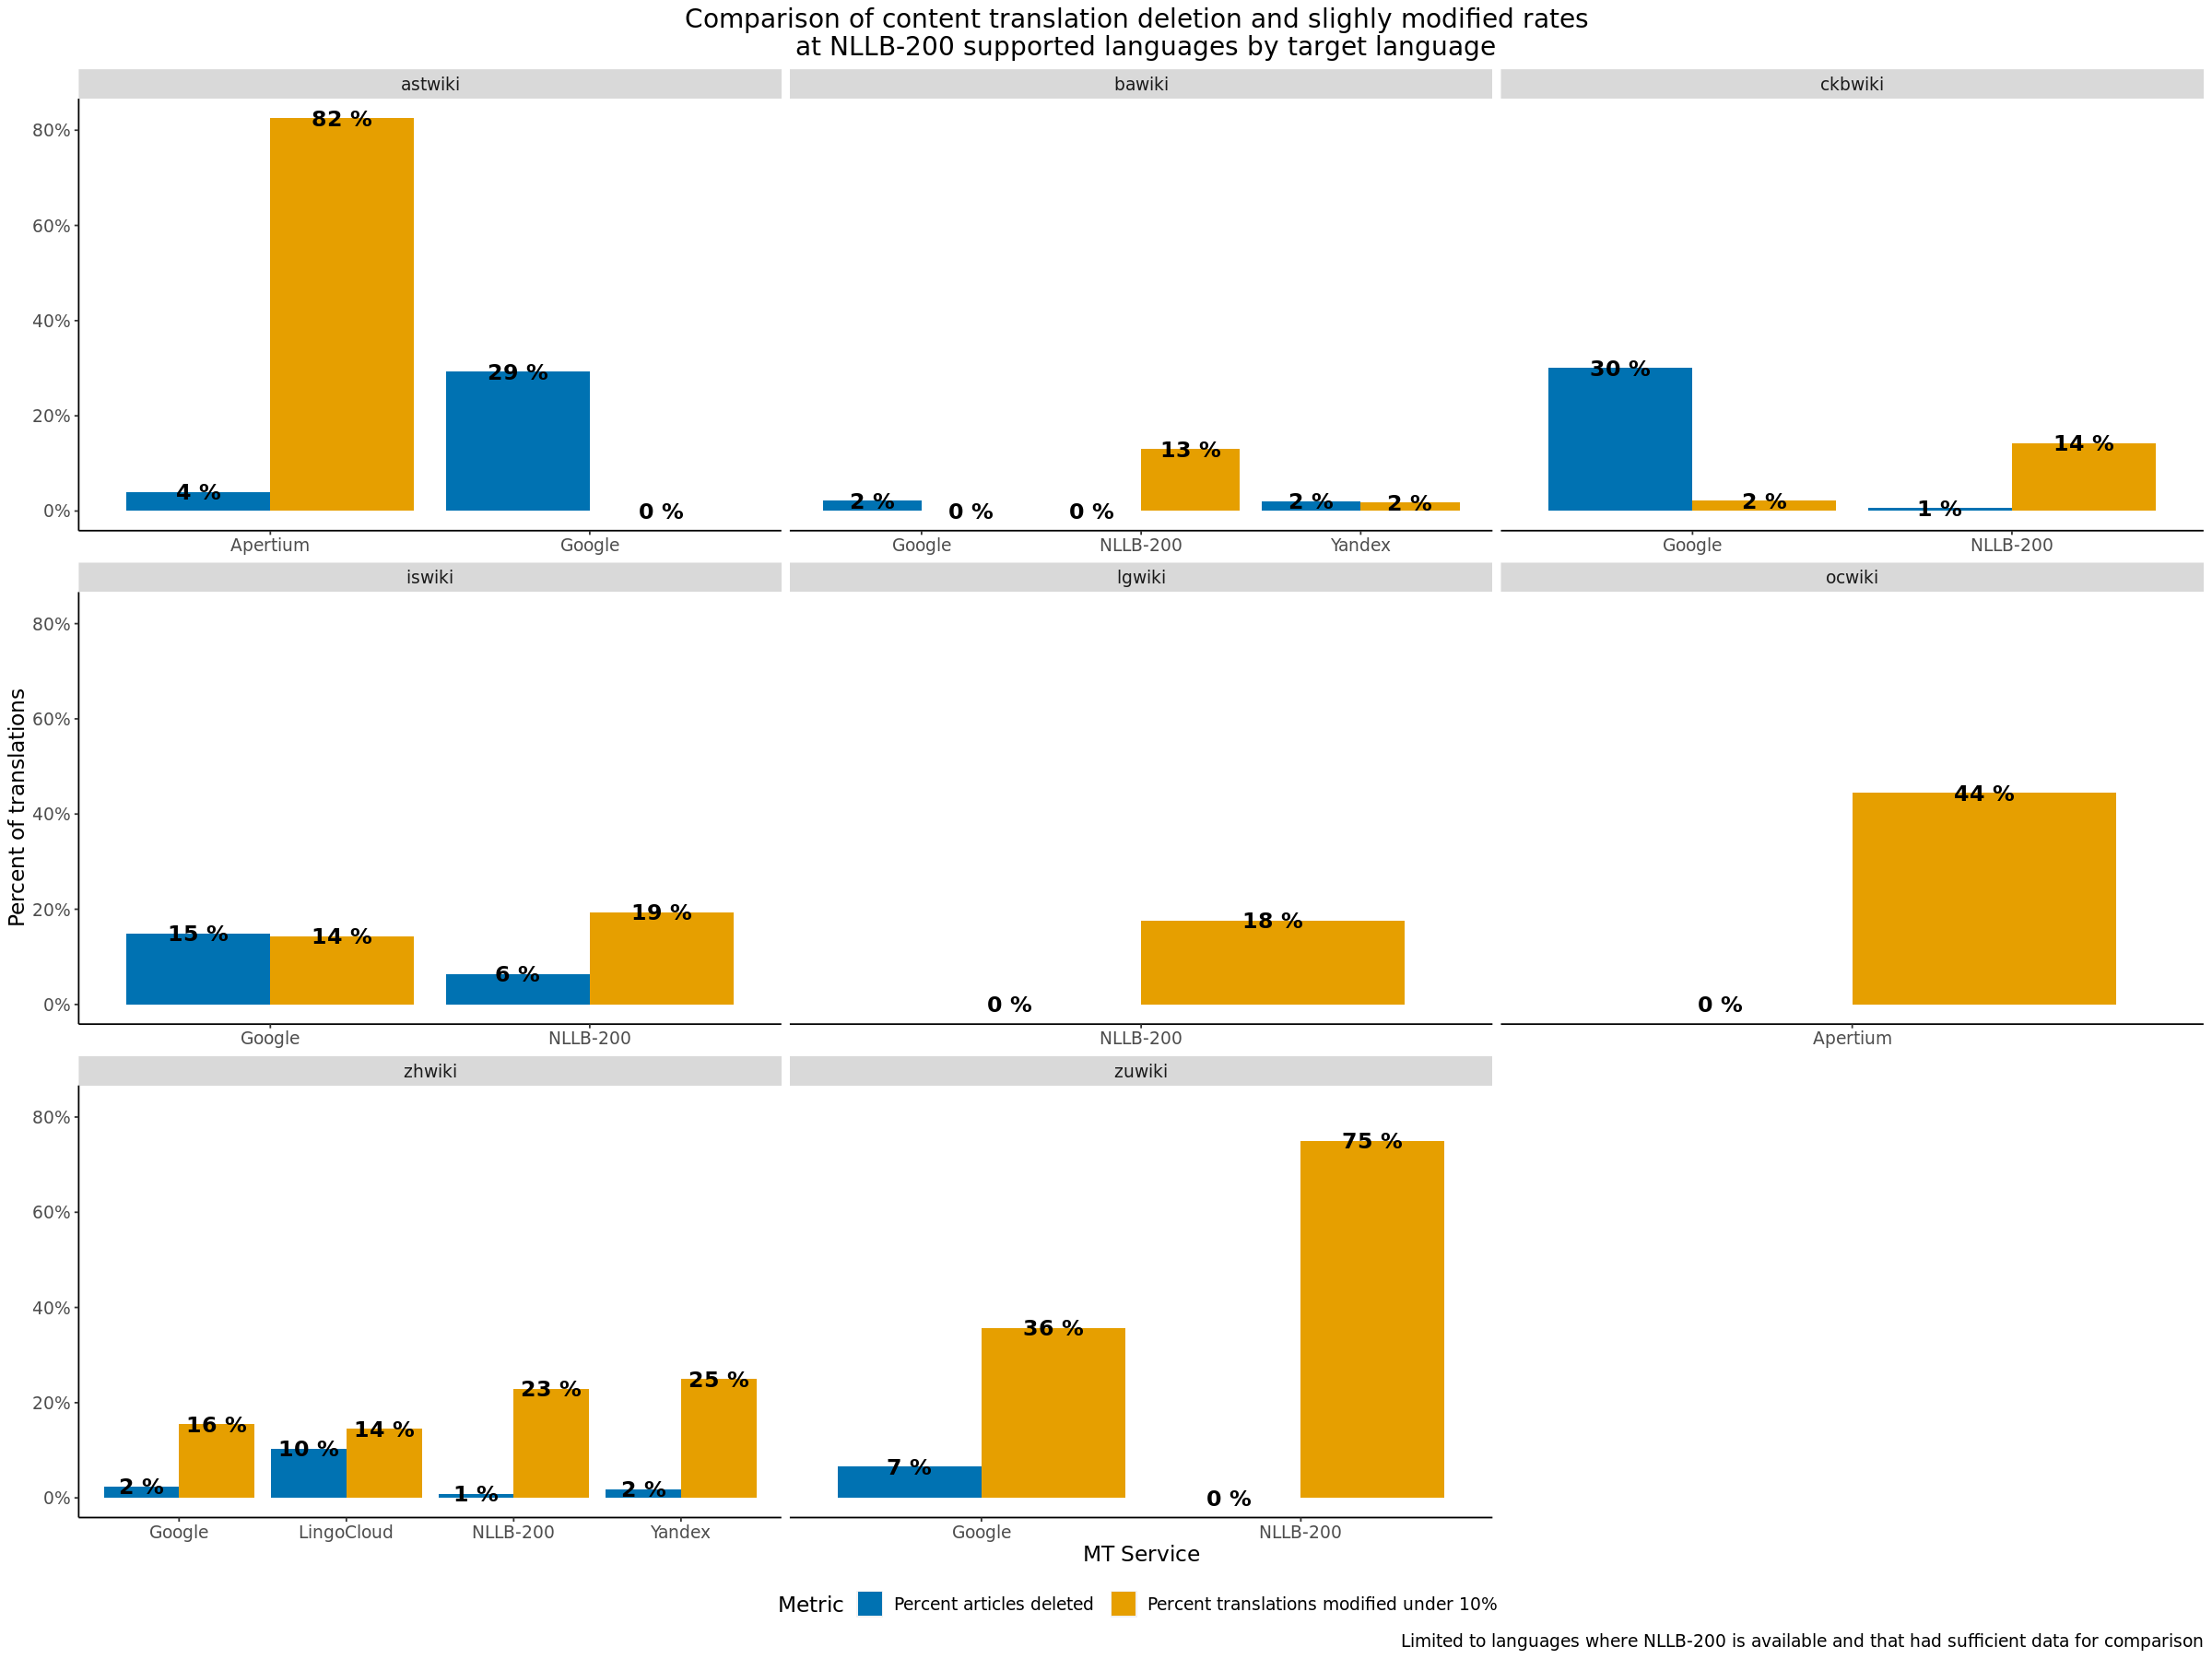

In [297]:
# Chart usage compared to other services

options(repr.plot.width = 20, repr.plot.height = 15)

p <- nllb_supported_lang_bywiki_plot %>%
        ggplot(aes(x = mt_service, y= percent, fill = factor(metric),
                  label = paste(round(percent * 100,0), "%")) ) +
        geom_col(position = 'dodge') +
        #coord_flip() +
        geom_text(size = 5, color = 'black', fontface = 'bold',  position = position_dodge(width = 0.9)) +
        facet_wrap(~wiki, scales = "free_x") +
        scale_y_continuous(labels = scales::percent) +
        scale_x_discrete() +
        labs (x = "MT Service",
              y = "Percent of translations",
             title = "Comparison of content translation deletion and slighly modified rates \n at NLLB-200 supported languages by target language",
              caption = "Limited to languages where NLLB-200 is available and that had sufficient data for comparison"
             ) +
         scale_fill_manual(values = c("#0072B2", "#E69F00"), labels = c("Percent articles deleted", "Percent translations modified under 10%")) +
         guides(fill=guide_legend(title="Metric")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/nllb_compare_mod_del.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p

#### Apertium Supported Languages

In [215]:
apertium_supported_lang_bywiki <- mt_deletion_bywiki_mod %>%
    # isolate to NLLB supported languages
 filter(wiki %in% c('mswiki', 'scwiki', 'ocwiki', 'hiwiki', 'itwiki', 'ptwiki',
'simplewiki','mkwiki','ukwiki','trwiki','urwiki','nowiki','eowiki','idwiki', 'eswiki','frwiki',
'iswiki','glwiki','svwiki','nnwiki','dawiki', 'cawiki', 'szlwiki', 'bnwiki','srwiki',
'ruwiki', 'bgwiki', 'tawiki', 'bswiki', 'shwiki', 'astwiki', 'bewiki'),
       created_cx_total > 100) %>%  #limited to wikis with at least 100 translations
    mutate(pct_deleted = round(deleted_cx_total/created_cx_total, 3))  %>% 
    gather(key = "metric", value = "percent", c( pct_modified_under10, pct_deleted)) %>% 
    filter(percent != 'NA' | percent != '0') #help focus on wikis where data was logged

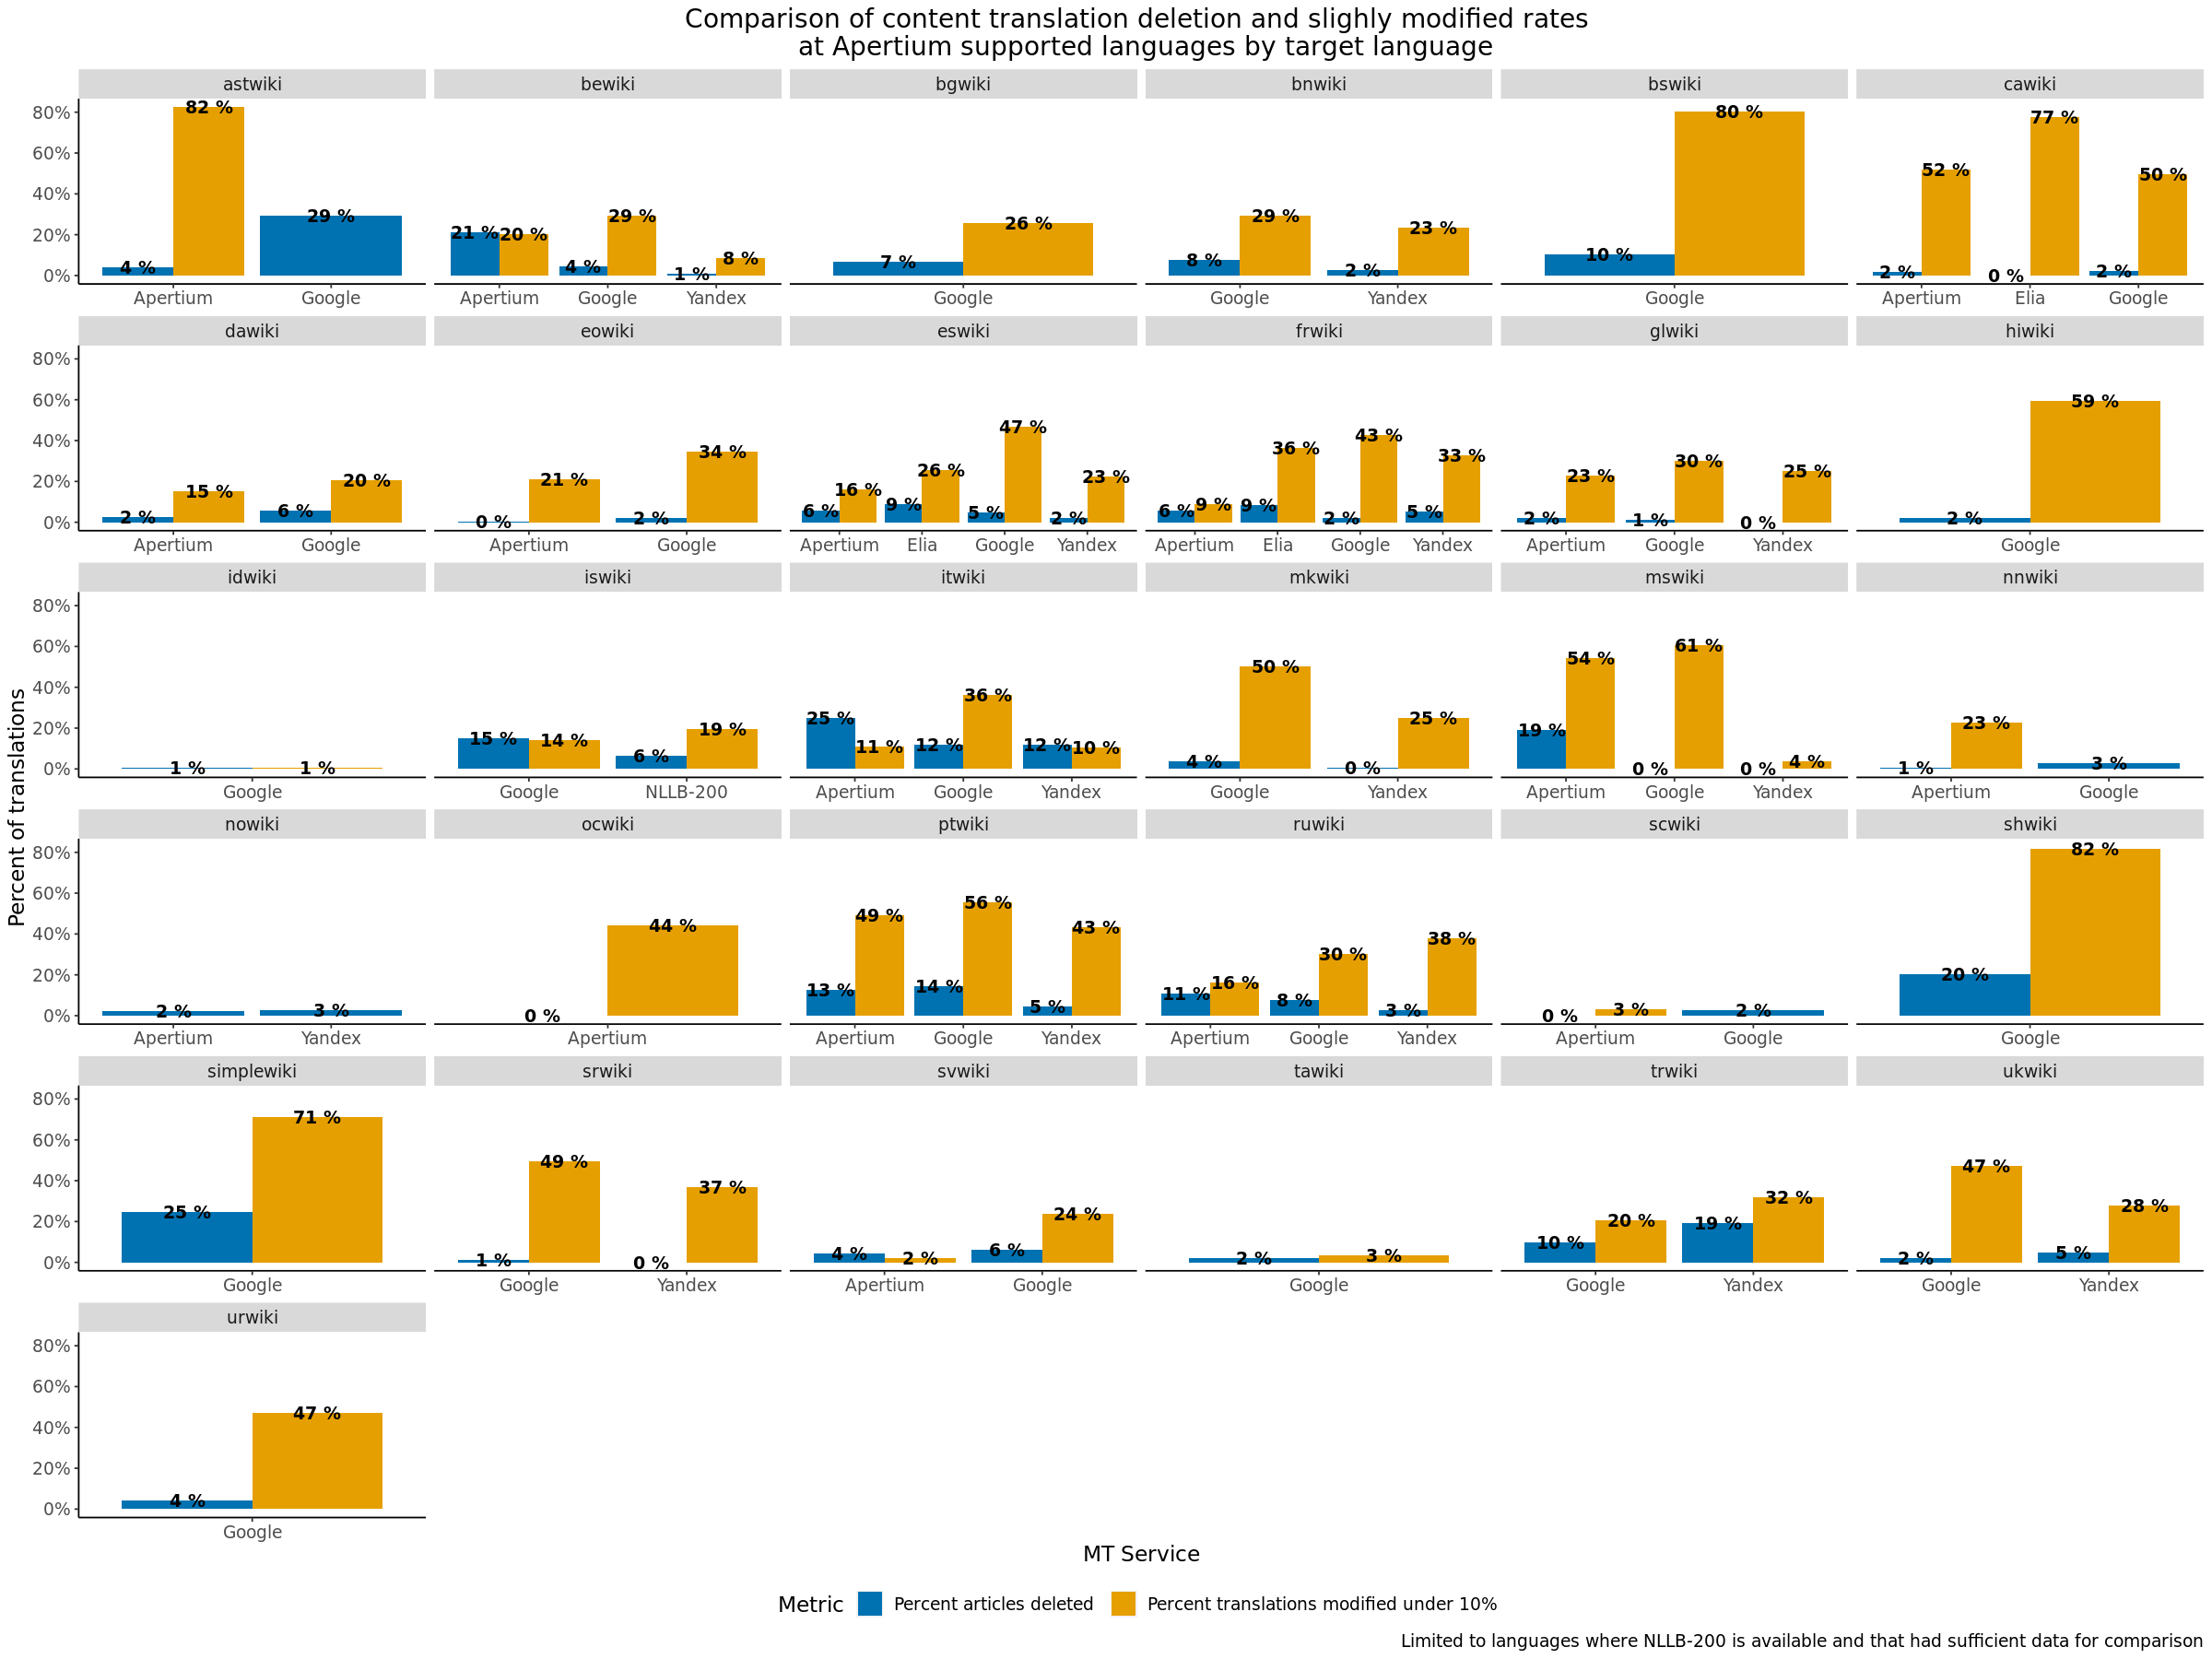

In [300]:
# Chart usage compared to other services

options(repr.plot.width = 20, repr.plot.height = 15)

p <- apertium_supported_lang_bywiki %>%
        ggplot(aes(x = mt_service, y= percent, fill = factor(metric),
                  label = paste(round(percent * 100,0), "%")) ) +
        geom_col(position = 'dodge') +
        #coord_flip() +
         geom_text(size = 4, color = 'black', fontface = 'bold',  position = position_dodge(width = 0.9)) +
        facet_wrap(~wiki, scales = "free_x") +
        scale_y_continuous(labels = scales::percent) +
        scale_x_discrete() +
        labs (x = "MT Service",
              y = "Percent of translations",
             title = "Comparison of content translation deletion and slighly modified rates \n at Apertium supported languages by target language",
              caption = "Limited to languages where NLLB-200 is available and that had sufficient data for comparison"
             ) +
         guides(fill=guide_legend(title="Metric")) +
         scale_fill_manual(values = c("#0072B2", "#E69F00"), labels = c("Percent articles deleted", "Percent translations modified under 10%")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
 ggsave("Figures/apertium_compare_mod_del.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p

The correlation between the rate of deletion and articles that are slightly modified varies based on target language.  